# Phoneme Language Model #
This notebook builds a language model over English sounds (also known as [phonemes](https://en.wikipedia.org/wiki/Phoneme)). Its goal is to model what it means to be a valid English pronunciation. In this notebook I'll use it to:
1. Identify which English pronunciations are most- and least-Englishlike. For example, I would expect "fun" to sound normal and a borrowed word like "cliché" to be less normal.
2. Generate novel words that aren't English words but sound like they could be.

I'll also dig into what the model has learned to see whether it has learned the [phonotactics rules](https://en.wikipedia.org/wiki/Phonotactics) that all English speakers subconsciously understand.

In [1]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [2]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## The Data ##
The data for this model comes from the [CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which contains over one hundred thousand pronunciations. Each pronuncation is in [ARPABET](https://en.wikipedia.org/wiki/ARPABET), a set of symbols for representing English speech sounds. In ARPABET the word "fish" is represented by the sequence of phonemes /F IH1 SH/. You can probably guess the first and third sounds. The vowel in the middle has "1" at the end to indicate it has the primary stress.

I'll use the `load_data` function in the `utils` module to load the Pronouncing Dictionary into a Pandas DataFrame.

In [3]:
df = load_data(True)

# TODO: put these two things in the actual load function

# TODO: have the word as the index

print(f"There are {len(df):,} pronunciations")

There are 124,996 pronunciations


Here are all of the rows for the orthographic word "tomato":

In [4]:
df.loc['tomato']

,pronunciation,pronunciation_string,length
word,,,
tomato,"(T, AH0, M, EY1, T, OW2)",T AH0 M EY1 T OW2,6
tomato,"(T, AH0, M, AA1, T, OW2)",T AH0 M AA1 T OW2,6


The raw pronunciation, which is a tuple of ARPABET phonemes, is in the `pronunciation` column:

In [5]:
df.loc['fish', 'pronunciation']

('F', 'IH1', 'SH')

## The Model ##
The actual model code is in the Python module `phoneme_lm.py`, but I'll give a quick overview here.

It's a fairly simple PyTorch neural network comprised of the following layers:
1. Embedding layer to translate each phoneme into a dense vector.
2. An recurrent neural network (RNN) layer that processes each input phoneme sequentially and for each step generates (a) a hidden representation to pass on to the next step and (b) an output.
3. A linear layer that decodes the outputes (2b) into distributions over each phoneme.

Let's go through a simple example of what happens when we pass the pronunciation `["F", "IH1", "SH"]` through the model. Ultimately what I want ouf of the model is a prediction at each position of what the next phoneme should be. For example, when a well trained model is processing "F" I would hope it assigns a high probability to "IH1" coming next.

First I'll define our model. Note that I'm not actually fitting the model to any data so the output will be random. The parameters aren't optimal, but again that doesn't matter here since I just want to show the flow of data through the network.

In [6]:
embedding_dimension = 10
hidden_dimension = 100

phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
lm = PhonemeLM(phoneme_to_idx, rnn_type='gru', embedding_dimension=10, hidden_dimension=100)

Next I'll define the pronuncation we'll be working with. This is the standard pronunciation of "fish".

In [ ]:
pronunciation = ["F", "IH1", "SH"]

Within the neural network, phonemes are represented as integer indices. So the phoneme "F" might correspond go 23. Overall there are MEOW distinct phonemes. The function `build_vocab` finds every distinct phoneme in the pronunciations and constructs a dictionary mapping each one to an integer.

In [19]:
print(f'There are {len(phoneme_to_idx)} distinct phonemes.')

Before passing the pronunciation into the neural network I need to add dummy tokens to the pronunciation indicating its start and end. This allows the model to learn transition probabilities from the start of the word to the first phoneme, and from the last phoneme to the end of the word. We end up with this: `["START", "F", "IH1", "SH", "END"]`.

I also need to translate each phoneme into an integer index within the model. The `encode_pronunciation` function handles both of these tasks. It uses the `phoneme_to_idx` mapping I built above.

In [ ]:
input_ = encode_pronunciation(pronunciation)
input_

Here is what each of those ints maps to:

In [ ]:
for idx in input_:
    phoneme = idx_to_phoneme[idx]
    print(f'{phoneme} => {idx}')

And now we're ready to pass the input into the model's `forward` function. You can see the full function in `phoneme_lm.py`, but I'll walk through it layer by layer here.

In Torch, the `forward` function is the forward pass through the network, taking in inputs and outputting predictions. This model's `forward` function expects a Tensor of dimension (number of batches, number of steps, vocabulary size).

In this case I have a single pronunciation so the batch size is 1.

In [ ]:
print("Input's shape:", input_shape)
batch_input = input_.unsqueeze(0)
print("Batch input's shape:", batch_input.shape)

The first thing the `forward` function does is embed each phoneme using an [nn.Embedding](https://pytorch.org/docs/stable/nn.html#embedding). Each phoneme has a dedicated embedding vector of length `embedding_dimension`.

In [ ]:
embedded = lm.embedding(batch_input)
print(embedded.shape)

print(embedded[adsf])

The entire embedding is of the shape (meow), with M representing the number of phonemes in the input (including the dummy ones) and N repreesnting the embedding dimension.

*Side Note*: I want to talk a little bit about why embeddings are useful and whether they make sense here.

For this language model the vocabulary is the set of possible phonemes, of which there are MEOW. In most natural language processing tasks the tokens in the vocabulary are words (e.g. "cat", "threw"), where there are likely to be tens of thousands. So when embedding words using an embedding dimension of 100, each word is represented by a dense vector of 100 floats. Without embeddings you would need to represent each of your words with a one hot vector the size of your entire vocabulary. So embeddings result in fewer model parameters since the model only needs to know about those 100 floats. Since embeddings are updated during backpropagation, the model learns how to represent each token as a vector.

For this phoneme language model the vocabulary size is already very small to begin with and I initially was going to just represent each phoneme with a one hot vector. However, I wanted to use embeddings because I was hoping that the model would learn to represent each phoneme as its component parts. For example, the embedding space could capture whether a phoneme is a vowel or a consonant, whether it's [voiced or voiceless](https://en.wikipedia.org/wiki/Voice_(phonetics)), how [sonorant](https://en.wikipedia.org/wiki/Sonorant) it is, etc. Some limited probing of the embeddings generated didn't turn up anything too interesting (see more below) so I'm not sure how much they're helping, if at all. I have not measured model performance just using one hot encoding, but I wouldn't be surprised if it were equal or better.

So now we have the output of our embedding layer. We can pass this through the RNN layer, resulting in `rnn_output` and `hidden_state`. I won't go into detail on how RNNs work, but the basic idea is it has shared weights that are applied sequentially to every token (i.e. step) in the input. At each step an output and a hidden state are produced. The hidden state can be passed on to the next step, and the output can be used to make a prediction.

The `rnn` layer below operates on the full sequence, so the results are for the entire sequence.

In [20]:
rnn_output, hidden_state = lm.rnn(embedded)
print(rnn_output.shape)

NameError: name 'embedded' is not defined

For our application we can ignore the `hidden_state`-- the `rnn_output` is the interesting part. The shape of `rnn_output` is MEOW MEOW MEOW. The first dimension is for the batch, and we only have a single input in our batch. The second dimension is for each of the input phonemes: `input_` was of length MEOW so this is too. The third dimension corresponds to `hidden_dimension`: you can think of this as the state of the RNN at each step.

Now we're getting to the interesting part. As I said at the beginning of this section, I want the output of the RNN at each position to be predictions for the *next* position. So I'll apply a linear layer to the `rnn_output`, resulting in a vector the size of the vocabularly at each position. The [softmax](https://pytorch.org/docs/stable/nn.functional.html#softmax) function normalizes the outputs into probability distributions for each prediction.

In [ ]:
outputs = lm.linear(rnn_output)
probabilities = F.softmax(outputs, dim=-1).squeeze()
probabilities.shape

The shape of `probabilities` is MEOW X MEOW: for each of the MEOW phonemes in the input there's a distribution over all phonemes indicating what the model thinks the next phoneme in the input should be. The first phoneme in the input is the `START` token, so let's see what the model thinks should come next.

In [ ]:
probabilities_for_first_phoneme = probabilities[0]
print('The probabilities should sum to 1: ', probabilities_for_first_phoneme.sum())

In [ ]:
first_phoneme_idx = probabilities_for_first_phoneme.argmax()
first_phoneme_prob = probabilities_for_first_phoneme.max()
first_phoneme = idx_to_phoneme[first_phoneme_idx]
print(f'The first phoneme is most likely to be {first_phoneme}, with a probability of {first_phoneme_prob:.4f}')

MEOW update based on what actually comes out

Note that this isn't a very good prediction. If you look at the rest of the distribution you'll see it doesn't make sense. In order to get the model to make good predictions (e.g. that "S" is likely as the first phoneme in a word) we'll need to first train a good model.

## Finding the Best Model ##
In this section I'll train a number of models on the train set and select the one that has the lowest error on the dev set. I'll split the DataFrame of pronunciations into three DataFrames, with 79% for training, 20% for dev/validation, and 1% for testing of the final model.

In [12]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

Note that I ran a larger parameter search before and saw that GRUs were consistently outperforming LSTMs and vanilla RNNs. In the search below I'm looking for the model with the lowest dev error. There are 12 (4 * 3) models to build, and for each one I'm measuring train and dev error at every epoch. So if each model trains for the maximum of 2,000 epochs I would end up with 12 * 2,000 = 24,000 models to choose from. There's a good chance I'm overfitting the dev set with such a large search, but I'll inspect the learning curves to try to avoid selecting an iteration that randomly did well.

While each model trains for a maximum of 2000 epochs, it stops early if the dev error does not decrease for three epochs in a row. Since I'm going to be selecting the model with the lowest dev error there's no reason to keep training a model once it's started overfitting. Alternatively I could train all models to convergence and then add regularization to reduce the complexity and identify the sweet spot, but that's far more time consuming because it requires training more models and each of them for longer.

In [17]:
### THis is the old one that died

%%time

param_grid = ParameterGrid({
    'embedding_dimension': [10, 20, 50, 100],
    'hidden_dimension': [20, 50, 100],
})

records = []
for params in tqdm(param_grid):
    lm = PhonemeLM(
        phoneme_to_idx, rnn_type='gru', device='cuda', batch_size=1024,
        max_epochs=2000, early_stopping_rounds=2, **params
    )
    num_parameters = sum(len(layer) for layer in lm.parameters())

    print('Model Params:', params)
    train_losses, dev_losses = lm.fit(train_df.pronunciation.values.tolist(), dev_df.pronunciation.values.tolist())
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
        record['num_parameters'] = num_parameters
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

Model Params: {'embedding_dimension': 10, 'hidden_dimension': 20}
Epoch 1: train loss: 1.1936	assess loss: 1.6928
	Generated: in train: 1%, assess: 0%, novel: 99%
	 
	 R AO2 R EY2 ZH
	 OW2 Z V CH ER0 EH1
	 EH2 AE1 AO1 B CH OY0 L AH2 AW1
	 S AE0 OY0
Epoch 2: train loss: 0.9709	assess loss: 1.4515
	Generated: in train: 3%, assess: 0%, novel: 97%
	 EH1 IY2 S
	 M NG EH1 EH1 UW0 AO1 IH0 OW1
	 EH0 EY1
	 OW0 S UW T
	 K
Epoch 3: train loss: 0.8777	assess loss: 1.3323
	Generated: in train: 2%, assess: 0%, novel: 98%
	 OY0
	 T ER1 G
	 AA1 IY0 F
	 UW0 B NG AW0
	 OW1 AA2 P IY0
Epoch 4: train loss: 0.8195	assess loss: 1.2538
	Generated: in train: 5%, assess: 1%, novel: 94%
	 F START IH0 AY2
	 G UW1 D Z
	 UW2 S S D
	 OW2 IH0 N T S
	 EH2 G OY1 K S START AH0 K AE1 IH0
Epoch 5: train loss: 0.7805	assess loss: 1.1991
	Generated: in train: 3%, assess: 1%, novel: 96%
	 D AA0 K T AH0 ZH L K SH
	 UW1 UW2 EY0
	 ZH S AA1 F
	 AY1 K EY1 L S
	 TH
Epoch 6: train loss: 0.7515	assess loss: 1.1572
	Generated: in tra

Epoch 43: train loss: 0.5633	assess loss: 0.8728
	Generated: in train: 8%, assess: 1%, novel: 91%
	 B AH1 M
	 SH ER2 G HH IY1 S T
	 G AO1 R JH IH0 NG
	 K AA1 D AH0 N D ER0
	 K AE1 M D
Epoch 44: train loss: 0.5626	assess loss: 0.8718
	Generated: in train: 10%, assess: 1%, novel: 89%
	 T AA1 R T IY0 AH0 B ER0
	 S AA1 N N
	 W AH0 N IH1 L IY0
	 P AW1 Z
	 K EH1 K IY0 M UW2 N AH0 N
Epoch 45: train loss: 0.5620	assess loss: 0.8708
	Generated: in train: 13%, assess: 0%, novel: 87%
	 L EY1 K AO0 N
	 AY1 K IY0
	 AA1 M Z
	 TH UW1 P ER0
	 T R OW1 M IY0
Epoch 46: train loss: 0.5614	assess loss: 0.8698
	Generated: in train: 13%, assess: 2%, novel: 85%
	 Z IH1 K
	 IH0 N AA1 K L AY2 JH IH0 NG
	 EH0 L T AA0 S V EH1 N IY0 D AH0 N
	 HH EH1 L V ER0
	 SH EY1 SH AH0
Epoch 47: train loss: 0.5608	assess loss: 0.8690
	Generated: in train: 9%, assess: 1%, novel: 90%
	 B EH1 B S T R UH2 K ER0
	 B IH1 Z AH0 B EH0 L D
	 M AO1 R AH0 K AH0 N
	 S T EH1 NG K V AY2 N
	 P EH1 K M AH0 N
Epoch 48: train loss: 0.5603	asses

Epoch 84: train loss: 0.5493	assess loss: 0.8519
	Generated: in train: 5%, assess: 2%, novel: 93%
	 B UW1 Z
	 V R IY1 D
	 AA1 S M OW0
	 F AO2 S L UW1 V Z
	 IY0 G ER0 S UW2 N D IY1
Epoch 85: train loss: 0.5492	assess loss: 0.8517
	Generated: in train: 8%, assess: 2%, novel: 90%
	 HH UW1 G
	 HH AO1 R
	 D IH0 M IY1 P ER0 V UH1 K
	 CH UW0 AE1 T AH0 JH AH0 S
	 M AE1 DH ER0 L EH2 R AH0
Epoch 86: train loss: 0.5490	assess loss: 0.8514
	Generated: in train: 11%, assess: 2%, novel: 87%
	 D IY1 N T S
	 K AA1 S AH0 N Z
	 S AW1 T AH0 SH AH0 S EY2 N
	 L UW0 T AA2 N AA0 V AH0 N EY1 SH AH0 N
	 K AW2 L IH1 N T B ER0
Epoch 87: train loss: 0.5489	assess loss: 0.8513
	Generated: in train: 12%, assess: 0%, novel: 88%
	 D IH1 F IY0 ER0
	 AE1 L IY0 ER0 Z N AE2 R
	 K R EH1 NG K S T R OW2
	 F AH1 G N AH0 N D
	 G AH1 DH ER0
Epoch 88: train loss: 0.5488	assess loss: 0.8511
	Generated: in train: 9%, assess: 1%, novel: 90%
	 OW1 L EY2 T
	 AH0 N S EH1 F T IH0 NG
	 S OW0 K EH1 L IH0 NG
	 P UW2 G AA1 R D AH0
	 AA2 L

Epoch 165: train loss: 0.5430	assess loss: 0.8427
	Generated: in train: 13%, assess: 1%, novel: 86%
	 S AY1 L
	 G R EH1 B AA2 F
	 M AE0 T N IH1 L IH0 K AH0 N
	 M AA1 R S IY0
	 Z OW1 L D
Epoch 166: train loss: 0.5430	assess loss: 0.8426
	Generated: in train: 15%, assess: 0%, novel: 85%
	 S ER1 D Z
	 T EH1 N IY0
	 P L OW1 TH W EY1 V AY2 K
	 IH2 N T ER0 EH1 SH N ER0
	 IH0 K S IY1 IH0 K
Epoch 167: train loss: 0.5429	assess loss: 0.8425
	Generated: in train: 10%, assess: 3%, novel: 87%
	 B OW1 L Z
	 L AO1 S AH0 M
	 HH AE1 NG M ER0 S AH0 N
	 L UW2 T IY0 T AA1 T AH0 T AY2 M
	 G R AH1 V T S
Epoch 168: train loss: 0.5428	assess loss: 0.8425
	Generated: in train: 13%, assess: 1%, novel: 86%
	 S AA0 S T EH1 N T IY0 S
	 P IH1 N T IH0 D
	 S K AA1 M W EY0
	 S N IY1 P AH0 L IH0 S IH0 NG
	 IH0 N D AE1 R IY0 AH0 T AY2 T
Epoch 169: train loss: 0.5428	assess loss: 0.8425
	Generated: in train: 7%, assess: 2%, novel: 91%
	 K AH0 N JH EY1 SH AH0 N
	 HH EH1 D OW2 M
	 B ER0 T EY1 SH AH0 N
	 K R AE1 S AH0 S T 

Epoch 207: train loss: 0.5416	assess loss: 0.8405
	Generated: in train: 11%, assess: 0%, novel: 89%
	 G R IH1 R D IH0 G
	 IH2 N IY0 T R IH1 M IH0 S
	 R IH1 S T IH0 NG
	 S IH0 N UW1 P AH0
	 L AH1 L ER0 Z
Epoch 208: train loss: 0.5414	assess loss: 0.8404
	Generated: in train: 9%, assess: 3%, novel: 88%
	 M IH1 B ER0 IH0 NG
	 D IY1 T AH0 D Z
	 B ER1 B IH0 K
	 HH Y UW1 P ER0 Z
	 F EH1 M
Epoch 209: train loss: 0.5414	assess loss: 0.8404
	Generated: in train: 13%, assess: 2%, novel: 85%
	 F OW0 L AH0 HH EH1 CH IH0 S T
	 K L AW1 S AH0 R
	 IH0 K AH0 T AA1 L OW0
	 P AE1 N AH0 N
	 P UW2 R W EY1 V IH0 M
Epoch 210: train loss: 0.5415	assess loss: 0.8405
	Generated: in train: 13%, assess: 2%, novel: 85%
	 D IH0 F R AE1 N AH0 N
	 EH1 R D IH0 S T AH0 N
	 IH0 K T UW0 K AA1 N OW0
	 OW0 S EH1 L IH0 NG
	 AE1 N T ER0 Z
Epoch 211: train loss: 0.5414	assess loss: 0.8404
	Generated: in train: 11%, assess: 0%, novel: 89%
	 M AY0 B IH0 S T ER0 OW0 N AA1 R OW0 Z
	 AH0 P R IY1 K
	 JH IH1 D IH0 L
	 W EH1 R IY0 EY

Epoch 248: train loss: 0.5405	assess loss: 0.8391
	Generated: in train: 10%, assess: 1%, novel: 89%
	 S T IH1 K R
	 AA0 L AA1 K IY0
	 Z IY1 ER0 D
	 W AY1 L D Z
	 B L AA1 M IH0 JH
Epoch 249: train loss: 0.5406	assess loss: 0.8392
	Generated: in train: 12%, assess: 1%, novel: 87%
	 M IH2 L IH0 S P EH1 M AH0 T ER0
	 M EH1 S K AH0 N
	 F IY1 M L AH0 N T
	 K AH1 P S K AA2 K
	 B AO1 R D IH0 T
Epoch 250: train loss: 0.5405	assess loss: 0.8390
	Generated: in train: 16%, assess: 1%, novel: 83%
	 K L AH1 K S
	 S ER0 P AY1 G AH0 L
	 D IH1 NG T Z IH2 Z IH0 NG
	 M AE1 B AH0
	 L IH0 G OW1 L
Epoch 251: train loss: 0.5405	assess loss: 0.8390
	Generated: in train: 16%, assess: 3%, novel: 81%
	 HH EH1 R IH0 S T S
	 AA1 R L AH0 N
	 W AH1 D N ER0
	 M IH1 N ER0
	 D IH0 S P EH1 R OW0 Z
Epoch 252: train loss: 0.5405	assess loss: 0.8390
	Generated: in train: 20%, assess: 1%, novel: 79%
	 M AO1 R T M AH0 N
	 T AA2 P IY0 N EH1 N D IY0 AH0
	 P EY1 M AH0 N
	 JH AH0 N AA1 T AH0 Z
	 V IY0 T AA1 R IY0 AE0 N
Epoch 253

Epoch 289: train loss: 0.5398	assess loss: 0.8381
	Generated: in train: 9%, assess: 1%, novel: 90%
	 SH EY1 S T
	 P ER1 B IY0 IH0 D
	 EH2 R AH0 JH EH1 D W EY0 N ER0
	 R EY1 ER0 T IH0 D
	 L OW1 B AH0 N D
Epoch 290: train loss: 0.5398	assess loss: 0.8381
	Generated: in train: 8%, assess: 4%, novel: 88%
	 M EH1 S T IH0 S IH0 NG AH0 N
	 K HH AA1 L F T R EY2 T
	 B EH1 L AH0 N D AH0 N S
	 P R IY0 AA1 R S IY0
	 B IH1 N Z
Epoch 291: train loss: 0.5398	assess loss: 0.8380
	Generated: in train: 9%, assess: 2%, novel: 89%
	 P AA2 N T EY1 L AH0 K L IY0
	 S EH0 L AE1 T OW0
	 D IH0 P OW0 N OW0 S IY0 T OW1 N IY0
	 K R AE1 T IH0 K AH0 L Z
	 S EH1 Y AH0 M AH0 L
Epoch 292: train loss: 0.5399	assess loss: 0.8381
	Generated: in train: 13%, assess: 5%, novel: 82%
	 HH AH1 K ER0
	 M AO1 R Z
	 D IH0 G AE1 SH IY0 AH0 T
	 CH IH1 T
	 M IH1 Z AH0 D ER0
Epoch 293: train loss: 0.5398	assess loss: 0.8380
	Generated: in train: 11%, assess: 0%, novel: 89%
	 L IY1 EY2 T IH0 NG
	 B IY1 V IY0
	 S K W IH1 M IH0 N Z
	 B A

Epoch 331: train loss: 0.5392	assess loss: 0.8372
	Generated: in train: 5%, assess: 2%, novel: 93%
	 P IH1 L OW0 HH AY0 P TH
	 AE2 V IH0 S EY1 SH AH0 N Z
	 K AO1 R B EY2
	 P W IH1 R
	 D UW2 L EH1 G R AH0 L IY0
Epoch 332: train loss: 0.5392	assess loss: 0.8372
	Generated: in train: 13%, assess: 3%, novel: 84%
	 S AA1 N S L IY0
	 HH IH0 L OW1 V AH0
	 D IY0 P AA1 R T S
	 TH IH1 N D IH0 K AE2 T
	 G IY1 HH AH0 L IH0 S
Epoch 333: train loss: 0.5392	assess loss: 0.8373
	Generated: in train: 11%, assess: 0%, novel: 89%
	 K UW1 OW0
	 M AE1 N S L IY0 G AY2 N
	 IH0 K AA0 N V EH1 R
	 AE1 M P AH0 P
	 K OW0 T R AE2 S EH1 L Y AH0 N
Epoch 334: train loss: 0.5392	assess loss: 0.8372
	Generated: in train: 10%, assess: 3%, novel: 87%
	 D AY1
	 M EH1 F L AH0 M
	 JH IH1 M Z
	 P UW1 B T
	 D IY0 M AE1 N
Epoch 335: train loss: 0.5392	assess loss: 0.8372
	Generated: in train: 14%, assess: 0%, novel: 86%
	 T AA0 R V IY2 IY0 AH0 N S AH1 Z M
	 D EH1 R IH0 T ER0
	 F AH0 K ER1 N JH AH0 S
	 AH0 N F EY2 N S T IH1 N D

Epoch 372: train loss: 0.5387	assess loss: 0.8365
	Generated: in train: 7%, assess: 2%, novel: 91%
	 M AH0 N UW1 D AH0
	 P EY1 K EY2
	 AA1 L M IY0 AH0 L Z
	 G AY1 Z AH0 N S T
	 S K EH1 K S T
Epoch 373: train loss: 0.5387	assess loss: 0.8365
	Generated: in train: 11%, assess: 3%, novel: 86%
	 M AY0 OW1 L OW0
	 B AY1 N T ER0 AH0 N
	 S T UH1 N D ER0
	 S T AE1 SH IH0 Z
	 JH AH0 N T R AE1 K AH0 B AH0 B IY0
Epoch 374: train loss: 0.5387	assess loss: 0.8365
	Generated: in train: 14%, assess: 3%, novel: 83%
	 M IH1 B IH0 SH
	 HH AO1 R Z UW0
	 F IH1 T
	 S P ER1 M AY2 D
	 SH IH0 R AO1 R IY0
Epoch 375: train loss: 0.5387	assess loss: 0.8365
	Generated: in train: 10%, assess: 3%, novel: 87%
	 AE1 T L IH0 JH
	 M IH1 P CH AH0 N Z
	 F R EH2 G IH0 N EY1 SH AH0 N
	 HH IH1 S IH0 Z
	 S T AE1 N D AH0 N Z
Epoch 376: train loss: 0.5387	assess loss: 0.8364
	Generated: in train: 18%, assess: 0%, novel: 82%
	 Z IH0 S K AO1 R T IH0 D
	 TH EY1 D AH0 L L D
	 B AA1 R AH0 L
	 M AO1 T
	 F AO1 R V OW0
Epoch 377: trai

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.9577	assess loss: 1.4622
	Generated: in train: 2%, assess: 0%, novel: 98%
	 OY0 OW2 G ER1 W JH AO1 UW2
	 EY1 UH0 EH2 V D AA0 IH1 EY0
	 R UW OY0 OW1 ER2 OW1 UH1 AA1 DH L N Z AH0
	 ER0 OW1 EH1 G D
	 UW0 EY0 AY0 START Y P R UW0 UH1 AO0
Epoch 2: train loss: 0.8414	assess loss: 1.2904
	Generated: in train: 2%, assess: 0%, novel: 98%
	 EY2 AY2 UH2
	 IH2 UW1 W D
	 AW2 JH AH2 OY0
	 ER2 V L AO1
	 
Epoch 3: train loss: 0.7782	assess loss: 1.2004
	Generated: in train: 4%, assess: 0%, novel: 96%
	 AH2 UW Z M S
	 D K D N IH1 D NG AH1 L
	 UW1
	 CH EY0 OY0 ER2
	 AH2 S D AE1
Epoch 4: train loss: 0.7380	assess loss: 1.1402
	Generated: in train: 1%, assess: 0%, novel: 99%
	 P
	 T DH
	 D IY0
	 AW0 AH0 T ER2 T
	 D R T
Epoch 5: train loss: 0.7074	assess loss: 1.0940
	Generated: in train: 0%, assess: 0%, novel: 100%
	 EH1 OW1 R IY0
	 P R IH1
	 S AA1 AO1 AH0
	 D P Y EY1 T M N L
	 K G S R EH0 K AH0 P AE2 N D
Epoch 6: train loss: 0.6832	assess loss: 1.0570
	Generated: in train: 3%, asses

Epoch 43: train loss: 0.5387	assess loss: 0.8366
	Generated: in train: 9%, assess: 1%, novel: 90%
	 M EH1 L AH0 N
	 V EH2 N
	 M IH1 S T R IY0
	 K AH1 S M AH0
	 P AA1 P EH0 K
Epoch 44: train loss: 0.5381	assess loss: 0.8357
	Generated: in train: 9%, assess: 3%, novel: 88%
	 HH AA0 M EH1 T IY0
	 B ER1 T ER0 IY0
	 M AH0 S IY1 K
	 D IH0 F IH1 K SH IH0 Z
	 P AA2 N T IY0 AE1 N
Epoch 45: train loss: 0.5374	assess loss: 0.8347
	Generated: in train: 9%, assess: 2%, novel: 89%
	 L AW1 AH0 T EY2 T S
	 AE2 N S EY2 T S K OW1 S IY0 AH0
	 W IH1 B ER0
	 P AE1 S IH0 K
	 L AA1 HH UH1 ER0
Epoch 46: train loss: 0.5368	assess loss: 0.8338
	Generated: in train: 13%, assess: 2%, novel: 85%
	 W AH1 T
	 F EH1 R AH0 N IY2 Z
	 L IH1 B AH0 L IY0
	 JH ER1 N IH0 NG
	 P IH1 Z IH0 N T ER0 N Z
Epoch 47: train loss: 0.5362	assess loss: 0.8330
	Generated: in train: 15%, assess: 3%, novel: 82%
	 S P R AY1
	 K AA0 N T R EY1 M Y UW2 Z
	 M AA1 K AH0 Z R AH2 N D
	 CH AA1 G ER0 Z
	 P ER0 N AA1 D IY0
Epoch 48: train loss: 0.53

Epoch 85: train loss: 0.5245	assess loss: 0.8168
	Generated: in train: 9%, assess: 3%, novel: 88%
	 M EH1 D ER0 D
	 K AA1 L HH UH2 F
	 M AH0 HH OW1 SH AH0 L JH IY1 K S
	 D IH1 NG HH IH0 N D
	 Y AA1 V IH0 G ER0
Epoch 86: train loss: 0.5242	assess loss: 0.8164
	Generated: in train: 14%, assess: 2%, novel: 84%
	 S T R OY1 S CH ER0 Z
	 D AO1 P
	 D IH1 N
	 F IY1 CH
	 R AW1 SH AH0 N
Epoch 87: train loss: 0.5241	assess loss: 0.8163
	Generated: in train: 18%, assess: 1%, novel: 81%
	 L ER1
	 L AE1 HH AH0
	 N EY1 M ER0
	 TH OW1 T IH0 SH T
	 P IH1 K AH0 L
Epoch 88: train loss: 0.5239	assess loss: 0.8160
	Generated: in train: 14%, assess: 1%, novel: 85%
	 P R AA1 S K
	 HH AA1 K S M AH0 N
	 K AA1 F S AH0 N
	 S IH1 N B ER2 G AH0 L
	 S K EH1 N D L IH0 NG
Epoch 89: train loss: 0.5239	assess loss: 0.8161
	Generated: in train: 12%, assess: 1%, novel: 87%
	 N AA1 K W ER0 S AH0 N
	 HH EH1 M AH0 N Z
	 Y IY1 Z
	 R EH2 N IH0 T OW0 W EY0 T IH1 SH AH0 L
	 W AO1 NG D
Epoch 90: train loss: 0.5236	assess loss: 0

Epoch 127: train loss: 0.5197	assess loss: 0.8107
	Generated: in train: 16%, assess: 2%, novel: 82%
	 S AY1 D W EH0 L
	 B AE1 NG K
	 AY0 IY1 T IY0 N
	 AH0 N OW1 L
	 M AH1 D IY0 M AH0 N
Epoch 128: train loss: 0.5196	assess loss: 0.8106
	Generated: in train: 8%, assess: 1%, novel: 91%
	 T IY0 SH IY1 AH0 S
	 B IH0 S W EY1 K AH0 N S AH0 N
	 S T EH1 M P IY0 AH0
	 AE2 N V AY2 V R EH1 SH AH0 N
	 W IH1 N D ER0 T IY0 Z
Epoch 129: train loss: 0.5196	assess loss: 0.8107
	Generated: in train: 18%, assess: 0%, novel: 82%
	 K AE1 P
	 EH1 K S ER0 T EY2 V ER0 Z
	 EY0 L AH0 P EH1 R IH0 K AH0 L IY0
	 L IH1 S
	 AE2 L T AY2 K EY1 SH AH0 N
Epoch 130: train loss: 0.5196	assess loss: 0.8106
	Generated: in train: 15%, assess: 3%, novel: 82%
	 K AA1 L K
	 SH AE1 T F ER0 D
	 HH EY1 T
	 T R EY2 M IH0 T IH1 N Y UW2 N Z
	 N AH1 L AH0 T AO2 R IY0
Epoch 131: train loss: 0.5195	assess loss: 0.8104
	Generated: in train: 14%, assess: 2%, novel: 84%
	 UW1 ER0
	 AE0 G B L UW1 T IH0 D
	 W UH1 L ER0 D
	 K L AH0 G N EH1 L
	

Epoch 169: train loss: 0.5174	assess loss: 0.8079
	Generated: in train: 9%, assess: 1%, novel: 90%
	 B AE2 T R AH0 S IH1 S T IH0 K
	 W AO1 R P
	 AH0 S P AY1 N HH AE2 F S
	 JH AA1 Z AA0 G
	 M ER0 EH1 V
Epoch 170: train loss: 0.5173	assess loss: 0.8079
	Generated: in train: 16%, assess: 2%, novel: 82%
	 F R AO1 D D
	 IH0 N T R UW1 B EH0 K T
	 M IH2 S AH0 G IH1 P AH0 L EH0 S
	 R EH2 N D AH0 N OW1
	 K OW1 L IH0 N
Epoch 171: train loss: 0.5173	assess loss: 0.8077
	Generated: in train: 13%, assess: 1%, novel: 86%
	 L AA1 K L IH0 NG
	 L IH1 S AH0
	 R IY0 HH W AA1 N D
	 K W IY1 D ER0 IY0
	 IH0 K SH UW1 K ER0
Epoch 172: train loss: 0.5172	assess loss: 0.8077
	Generated: in train: 14%, assess: 1%, novel: 85%
	 Z AE1 R AH0 L AH0 N
	 IH0 K S P AO1 R T IH0 NG
	 G R UW1 N AH0
	 AH0 G AE1 N V IH0 T S
	 K Y UW2 N IY0 EY1 SH AH0 N Z
Epoch 173: train loss: 0.5172	assess loss: 0.8077
	Generated: in train: 18%, assess: 1%, novel: 81%
	 EH1 R AH0 M AE0 S T
	 K AO1 R N D AH0 L
	 EH1 K
	 AE0 D V EY1 V IH0 NG

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8611	assess loss: 1.3196
	Generated: in train: 4%, assess: 0%, novel: 96%
	 EY2 ER1 START
	 CH M K EH2 N Z W
	 DH Z AH1
	 
	 
Epoch 2: train loss: 0.7708	assess loss: 1.1907
	Generated: in train: 1%, assess: 0%, novel: 99%
	 OW0 R IY1 ER0 D
	 EY1 HH
	 D L OY2 R AH0 M W
	 
	 DH AE1 ER0 T B
Epoch 3: train loss: 0.7233	assess loss: 1.1190
	Generated: in train: 2%, assess: 0%, novel: 98%
	 OY2 K R IY0 N
	 AE1 T N S
	 B B T B
	 N S R IH0 AH0 NG IH0 S
	 B AH0 L F OW2
Epoch 4: train loss: 0.6896	assess loss: 1.0677
	Generated: in train: 0%, assess: 0%, novel: 100%
	 T R AH0 ER0 N
	 AY1 IY1
	 AO1 L B S S IY0 NG Z L ER0
	 D R AH0 B EH1 S
	 R IY0 JH S IY1 D N
Epoch 5: train loss: 0.6616	assess loss: 1.0247
	Generated: in train: 3%, assess: 1%, novel: 96%
	 K NG N AH0 N F
	 F UW1 ER0 M
	 K IH1 L M S
	 S AH1 IY1 D R
	 G EH1 M T P
Epoch 6: train loss: 0.6401	assess loss: 0.9916
	Generated: in train: 3%, assess: 0%, novel: 97%
	 S AH0 N K T R IY0
	 OW2 IY1 K IY0 EY2
	 P R AA1 

Epoch 43: train loss: 0.5207	assess loss: 0.8118
	Generated: in train: 10%, assess: 1%, novel: 89%
	 R OW1 L IY0
	 B UW0 L AA1 N AH0
	 M IY1 G IY0
	 HH OW1 B IH0 N D
	 K AH0 B Y UW1 L AH0 D AY0 R
Epoch 44: train loss: 0.5199	assess loss: 0.8107
	Generated: in train: 14%, assess: 5%, novel: 81%
	 B AH1 D Z
	 W AO1 R D AH0 N
	 F EH1 N AH0 N IH0 S T S
	 W UH1 R G AO2 R D
	 T AO1 S T
Epoch 45: train loss: 0.5194	assess loss: 0.8103
	Generated: in train: 19%, assess: 0%, novel: 81%
	 L AE1 F S K IY0
	 AH0 N AY1 T R AH0 S IH0 Z
	 EH1 NG G R AH0 S T
	 K AA1 K AH0 L
	 B AO1 R Z
Epoch 46: train loss: 0.5186	assess loss: 0.8093
	Generated: in train: 13%, assess: 1%, novel: 86%
	 R IH1 F T
	 JH IH0 L IY1 T
	 K UW1 CH N IH0 NG
	 JH AE2 L P IH0 SH EH0 P EY1 SH AH0 N
	 B EH2 R AH0 G R OY1 M AH0 N T
Epoch 47: train loss: 0.5180	assess loss: 0.8085
	Generated: in train: 14%, assess: 3%, novel: 83%
	 AA1 Z IY0 OW0
	 D AH1 L M ER0
	 K AE1 M P AH0 L ER0
	 AE1 K L IY0
	 Y AH0 K EH1 N CH AH0 L Z
Epoch 48: 

	Generated: in train: 7%, assess: 1%, novel: 92%
	 SH AE1 M B ER0 L IY0 Z
	 M AA0 R AA1 N AH0
	 G AA0 R B AY1 S K IY0
	 D IH0 N AH1 L T IH0 NG
	 B AH1 S M AH0 N
Epoch 85: train loss: 0.5043	assess loss: 0.7943
	Generated: in train: 22%, assess: 1%, novel: 77%
	 P ER1 SH AH0 N T R AY2 T S
	 OW0 B OW1 S
	 IH2 N T AH0 M AA1 CH IH0 K L IY0
	 N EH1 T EH0 K
	 AE2 N IH0 L EH1 T IY0
Epoch 86: train loss: 0.5042	assess loss: 0.7942
	Generated: in train: 10%, assess: 0%, novel: 90%
	 K UW1 S AH0 M
	 K AH0 B AA1 L OW0
	 B IH1 T Z AH0 N
	 R IY0 Z AH1 M P
	 T R OW1 Z AH0 N B EH2 R IY0
Epoch 87: train loss: 0.5038	assess loss: 0.7937
	Generated: in train: 13%, assess: 2%, novel: 85%
	 AH1 B L IY0
	 R IY2 IH0 F S T R AH1 K T
	 V EY2 L IH0 G F AA1 R Z
	 G ER1 T
	 AH0 N S AO1 R D IH0 D Z
Epoch 88: train loss: 0.5037	assess loss: 0.7938
	Generated: in train: 17%, assess: 2%, novel: 81%
	 M AH1 M B EH0 S S
	 B OW1 L
	 K OW1 F AA2 S IH0 F
	 S AA1 CH R UW2 Z
	 S AY1 N T R AE2 G ER0
Epoch 89: train loss: 0.

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 1.1544	assess loss: 1.6571
	Generated: in train: 2%, assess: 0%, novel: 98%
	 TH W AO2 R AA2 UW1 START IH0 IH1 B HH
	 AY1 AO0 AA0 W
	 IH1 IY2
	 DH AA1 AA1 K OW2
	 DH UW OW0 EH1 UH0
Epoch 2: train loss: 0.9192	assess loss: 1.3798
	Generated: in train: 3%, assess: 0%, novel: 97%
	 IH0 DH OW2 B AO0
	 W IH0 ER2
	 AH0 UH1 R
	 AW0 ER1 AW1
	 EY2 ER1 N UH2 AA1 G OY2
Epoch 3: train loss: 0.8186	assess loss: 1.2452
	Generated: in train: 2%, assess: 1%, novel: 97%
	 P AY1 AA0 B K
	 K JH IH0 K IY0 ZH AW1 IH1 D ER1 IH2 N
	 AE1 R R IY0
	 R Z AY2 IY0 ER1
	 AH0 AH1
Epoch 4: train loss: 0.7619	assess loss: 1.1666
	Generated: in train: 6%, assess: 0%, novel: 94%
	 EH0
	 UH2 N N B
	 EY0 P T IH0
	 K IH0 F N T B
	 M EH1 L N IH0 OW2 D EH0 IH0 IH1 N AH0 N
Epoch 5: train loss: 0.7235	assess loss: 1.1115
	Generated: in train: 0%, assess: 1%, novel: 99%
	 M UW0 M IH0 G UW2 AE1 R M IY0
	 EH1 T EH1
	 M IH0 R AO2 N AE1 B
	 NG P R N AO1
	 AA1 EH2 L IY0
Epoch 6: train loss: 0.6945	assess loss: 1

Epoch 84: train loss: 0.5451	assess loss: 0.8460
	Generated: in train: 8%, assess: 1%, novel: 91%
	 K IY0 L AE1 NG K AH0 S
	 K AH1 L D ER0
	 G AH0 S EH1 L IY0
	 L R AH0 P S IH1 N IY0 AH0 N Z
	 K AA1 L N IH0 K
Epoch 85: train loss: 0.5449	assess loss: 0.8456
	Generated: in train: 11%, assess: 2%, novel: 87%
	 AA0 N D AA1 R CH AH0
	 M EH1 M P
	 S IH0 S IH1 D IY0
	 K EH1 L IH0 N
	 Y UW1 D AH0 L
Epoch 86: train loss: 0.5448	assess loss: 0.8454
	Generated: in train: 15%, assess: 1%, novel: 84%
	 T IH1 G ER0
	 L AO1 N S AH0 N D Z
	 AO1 L AH0 N D
	 K EH1 N T AH0 K IH0 T
	 M W AY1 OW0 G AA0 N
Epoch 87: train loss: 0.5446	assess loss: 0.8452
	Generated: in train: 10%, assess: 0%, novel: 90%
	 P R OW1 Z IH0 Z
	 AW0 R AA0 R N IH1 N IY0
	 P UW1 T
	 D IH0 L IY1 V AH0
	 IH0 L K AO1 R N D AH0 N Z
Epoch 88: train loss: 0.5445	assess loss: 0.8451
	Generated: in train: 12%, assess: 0%, novel: 88%
	 M AH1 K ER0
	 S AY1 SH IY0 AH0 L
	 F IH0 N S IH1 N D AH0 L Z
	 HH AH1 F ER0 AH0 L EY2 T
	 M AE1 T R IH0 N 

Epoch 125: train loss: 0.5409	assess loss: 0.8398
	Generated: in train: 11%, assess: 2%, novel: 87%
	 B UH1 D W IY1 Z
	 L EY1 K M AH0 N
	 B EH1 R W ER0 IH0 NG
	 K AH0 N AA1 N T IY0 OW0
	 AA1 F S
Epoch 126: train loss: 0.5408	assess loss: 0.8396
	Generated: in train: 17%, assess: 1%, novel: 82%
	 HH W IH0 V EH1 N D ER0
	 P OW0 Y AA0 R EY1 TH AH0
	 P EY1 D AH0
	 M AH1 L IH0 K AH0 L
	 G AO1 D B AO0 CH
Epoch 127: train loss: 0.5407	assess loss: 0.8396
	Generated: in train: 11%, assess: 1%, novel: 88%
	 W AY1 D AO2
	 HH AY1 N T AH0 S
	 L OW2 V OW0 OW0 M IH1 N JH IH0 R
	 B L AY1 D
	 JH IH1 L B AH0 M
Epoch 128: train loss: 0.5407	assess loss: 0.8395
	Generated: in train: 15%, assess: 0%, novel: 85%
	 S UW1
	 P R AH1 NG K UW0
	 T R IH1 SH AH0
	 L IH1 F
	 L EY1 K AA0 Z
Epoch 129: train loss: 0.5406	assess loss: 0.8394
	Generated: in train: 16%, assess: 4%, novel: 80%
	 M AE1 N
	 T AE1 N HH AH0 N
	 M OW1 D IY0
	 P UW0 T AO1 Z AH0 L IH0 NG
	 S AO1 NG
Epoch 130: train loss: 0.5406	assess loss: 0.8

Epoch 167: train loss: 0.5388	assess loss: 0.8366
	Generated: in train: 12%, assess: 1%, novel: 87%
	 P AO1 S K AH0 N
	 P EH0 L D AA0 G R EY1 JH IH0 NG
	 D ER0 TH EY1 Z
	 M IH1 D IH0 NG
	 AE2 P S P AH0 N OW1 N T S
Epoch 168: train loss: 0.5387	assess loss: 0.8365
	Generated: in train: 8%, assess: 3%, novel: 89%
	 B AE1 F IY0
	 P AE1 T ER0
	 S T IH2 P EY1 P AH0 T IH0 D
	 M IH1 S IH0 L
	 K AE1 S T IH0 K AH0
Epoch 169: train loss: 0.5387	assess loss: 0.8366
	Generated: in train: 11%, assess: 2%, novel: 87%
	 AE1 M P AH0 S
	 K UW1 Z
	 K UW1 F EY2 T IH0 NG
	 P ER1 D D R AA2 ZH
	 S K AA1 L P AH0 L
Epoch 170: train loss: 0.5387	assess loss: 0.8364
	Generated: in train: 9%, assess: 1%, novel: 90%
	 Y UW1 JH
	 Y UW1 L
	 L AE1 F K AH0 T
	 G R EH1 NG K
	 HH AE1 NG G R AY2 F
Epoch 171: train loss: 0.5386	assess loss: 0.8363
	Generated: in train: 15%, assess: 2%, novel: 83%
	 D AY0 ER1 V Z
	 G R AA1 R K L IY0
	 HH EH1 K SH AH0 M
	 L AH2 T IH0 S K OW1 B
	 P EY1 AH0
Epoch 172: train loss: 0.5386	asse

Epoch 209: train loss: 0.5377	assess loss: 0.8349
	Generated: in train: 8%, assess: 1%, novel: 91%
	 SH AH1 M ER0 D
	 HH AE2 N AH0 V AE1 K OW0
	 B AE1 SH Y UW2 D Z
	 M AE2 P ER0 Y AH0 N Y UW2 SH ER0 AE1 JH UW0 SH AH0 N
	 K L IH1 T
Epoch 210: train loss: 0.5375	assess loss: 0.8348
	Generated: in train: 9%, assess: 3%, novel: 88%
	 AE0 N T AO2 R AH0 N IY1 SH AH0 N
	 R IY1 N IH0 N T S
	 T AH1 S T ER0 T
	 B IH2 S AH0 P AA1 R IY0
	 T AA1 Z T IH0 NG
Epoch 211: train loss: 0.5375	assess loss: 0.8348
	Generated: in train: 11%, assess: 1%, novel: 88%
	 B ER1 L
	 B AA1 R F L AE2 S T S
	 AE1 NG M IH0 N
	 S EH2 L P ER0 IY1 K
	 F AE1 N B AE2 R Z
Epoch 212: train loss: 0.5375	assess loss: 0.8346
	Generated: in train: 7%, assess: 0%, novel: 93%
	 B IH1 NG K AH0 TH
	 D IH0 N AA1 R T
	 AH0 F EH1 R OW0
	 L AH1 M P M AH0 N
	 AE1 L B IH0 NG
Epoch 213: train loss: 0.5375	assess loss: 0.8347
	Generated: in train: 10%, assess: 3%, novel: 87%
	 B Y UW1 L S
	 M AH0 K EY1 L Z
	 HH W AA1 D B AA0 N
	 P ER1 M OW0


Epoch 251: train loss: 0.5367	assess loss: 0.8335
	Generated: in train: 13%, assess: 2%, novel: 85%
	 S EH2 Z AH0 T AE1 T IH0 CH
	 EH0 N D AE1 G R AH0
	 M AH0 SH M IH2 N AH0 JH EH1 R AH0
	 F AA1 R M ER0
	 K Y UH1 R AH0 F AH0 M
Epoch 252: train loss: 0.5367	assess loss: 0.8336
	Generated: in train: 10%, assess: 1%, novel: 89%
	 W UH1 K AH1 S AH0 L D
	 R EH2 N T IH0 S T AE1 P M IH0 K
	 JH OW1
	 AE0 D F AO1 R P ER0
	 M AO1 R T IH0 M
Epoch 253: train loss: 0.5367	assess loss: 0.8336
	Generated: in train: 8%, assess: 0%, novel: 92%
	 L OW1 B R IY0
	 B AH1 S T AH0 D
	 B AA1 R K IY0
	 HH IY1 R M EY2 K ER0
	 W AA1 N L IY0
Epoch 254: train loss: 0.5367	assess loss: 0.8335
	Generated: in train: 7%, assess: 3%, novel: 90%
	 N AH0 P L EY1
	 K R AY1 ER0 D
	 N AH0 V EH1 L IY0
	 K AH1 NG G AH0 L
	 P AH0 V UW1 N AH0 K
Epoch 255: train loss: 0.5367	assess loss: 0.8336
	Generated: in train: 11%, assess: 1%, novel: 88%
	 D AH0 K F EH1 R F ER0 Z
	 Z IH1 G S
	 S L IH1 N TH IH0 N
	 R IY1 K AH0 M
	 K R EY1 D

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.9123	assess loss: 1.3890
	Generated: in train: 0%, assess: 1%, novel: 99%
	 AA1 AO1 V S P AW1 UW AA1 OW0
	 ER1 IY1 IH1 IY1
	 B AW1 EY2 IH0 IY0 IH2
	 AH0 ZH ZH Z CH R
	 AE1 P G T AW0 M
Epoch 2: train loss: 0.7785	assess loss: 1.1970
	Generated: in train: 0%, assess: 0%, novel: 100%
	 AH0 K S
	 IY0 T AE1 S
	 K N
	 NG IY0 B UW
	 OW1 W S K AH0
Epoch 3: train loss: 0.7315	assess loss: 1.1289
	Generated: in train: 2%, assess: 0%, novel: 98%
	 AY1 L IY0 UW S HH
	 
	 S R R R K IH0 AA1 UW
	 CH R EH0 IY0 K K
	 AH1 T L L
Epoch 4: train loss: 0.7052	assess loss: 1.0898
	Generated: in train: 4%, assess: 0%, novel: 96%
	 IY1 R R UW1 IH1 L ER0
	 AY1 Z
	 F JH IY0 IH0 AH0 D
	 IY1 M D AH0 ER0 AH0
	 NG R D JH K NG
Epoch 5: train loss: 0.6787	assess loss: 1.0496
	Generated: in train: 2%, assess: 1%, novel: 97%
	 Y K HH K
	 AE1 AO1 K R K AH0 AH0 N
	 AO1 D AA1 OY0
	 P EH1 N EH2 L AH0 L K T AH0 N N
	 P L EH1 L EY1 L AW1 L
Epoch 6: train loss: 0.6517	assess loss: 1.0083
	Generated: in t

Epoch 43: train loss: 0.5309	assess loss: 0.8251
	Generated: in train: 9%, assess: 2%, novel: 89%
	 F R AH0 JH IH1 SH UW0 T IH0 NG
	 D EH1 N IY0 AH0
	 P EH1 D B UW0 G ER0 AH0 S
	 K Y UW1 T AH0
	 CH AH1 V ER0 AH0 L
Epoch 44: train loss: 0.5303	assess loss: 0.8243
	Generated: in train: 12%, assess: 1%, novel: 87%
	 B R AA1 K OW0
	 K L AE1 T AH0 N B AY2 AH0 L
	 M EH0 L AH0 D ER1 D IH0 V AH0 L IY0
	 B R AY1 M AH0 N Z
	 D AE1 NG
Epoch 45: train loss: 0.5298	assess loss: 0.8235
	Generated: in train: 16%, assess: 4%, novel: 80%
	 T AY1 R AH0
	 F EH0 L OY1 P
	 K AH0 M AE1 D R AH0 F AH0 N T
	 B L OW0 JH EH1 S IY0 AH0 Z
	 L EH1 M N AH0 L Z
Epoch 46: train loss: 0.5293	assess loss: 0.8229
	Generated: in train: 17%, assess: 3%, novel: 80%
	 M EH1 S ER0 IY0
	 NG K R AH1 SH L IY0
	 Z EH1 L JH AH0 N
	 SH AY1 F UW0 N
	 K EY1 T
Epoch 47: train loss: 0.5289	assess loss: 0.8224
	Generated: in train: 17%, assess: 1%, novel: 82%
	 B AW1 N D ER0
	 T R OW1 T ER0 Z
	 AA1 L Z
	 TH AH1 N T S
	 R EH2 V Z EH1 M Y

Epoch 84: train loss: 0.5195	assess loss: 0.8099
	Generated: in train: 18%, assess: 1%, novel: 81%
	 P AH1 N S AO2 N T ER0 Z
	 S UW2 M ER0 AA1 SH AH0
	 T AO1 R T
	 S IH0 P AE1 K SH AH0 N
	 TH UH1 R G AH2 T
Epoch 85: train loss: 0.5193	assess loss: 0.8096
	Generated: in train: 14%, assess: 0%, novel: 86%
	 UW1 K
	 R AA1 N IH0 K
	 W EH1 L M ER0
	 G R AH1 CH IH0 K
	 OW2 V UW1 Z
Epoch 86: train loss: 0.5192	assess loss: 0.8094
	Generated: in train: 19%, assess: 0%, novel: 81%
	 F EH1 S T ER0
	 M AH0 L EH1 V R AH0 N S
	 R IH0 V ER1 S R IH0 N
	 Y IH0 R IH0 Z P Y UH1 R D
	 B UH1 S P EY2
Epoch 87: train loss: 0.5191	assess loss: 0.8093
	Generated: in train: 11%, assess: 3%, novel: 86%
	 TH IH1 T K AH0 N ER0 Z
	 IH1 N SH EH0 L AH0 T
	 F IH1 K T S
	 K AA0 V AE2 N T UW0 S OW0 OW0
	 K R EY1 B L AY2 N
Epoch 88: train loss: 0.5189	assess loss: 0.8092
	Generated: in train: 11%, assess: 0%, novel: 89%
	 M AE1 S P ER0 K IH2 L
	 S P AO1 R S T AH0 N
	 L IH1 T S AH0 N T
	 S AE1 N D R OY0 W IH0 S T
	 IH2 N

Epoch 125: train loss: 0.5155	assess loss: 0.8052
	Generated: in train: 16%, assess: 0%, novel: 84%
	 D UW1 L IY0 AH0 M
	 F AA1 CH IY0
	 M IH1 L AH0 M R AA2 N
	 T EY1 DH ER0 Z
	 W EH1 N T R AH0
Epoch 126: train loss: 0.5155	assess loss: 0.8051
	Generated: in train: 8%, assess: 1%, novel: 91%
	 AO1 L IY0
	 HH IY0 S AO1 R T
	 AH0 B N IH1 N D Z IY0
	 S ER1 V IH0 N
	 M AH0 G N AA1 R D
Epoch 127: train loss: 0.5155	assess loss: 0.8052
	Generated: in train: 15%, assess: 2%, novel: 83%
	 R AW1 T
	 R AH0 Z IH1 L IH0 T Z
	 AH0 M AE1 R AH0 T IH0 S T S
	 P IY1 G
	 HH W IH1 CH
Epoch 128: train loss: 0.5154	assess loss: 0.8052
	Generated: in train: 15%, assess: 0%, novel: 85%
	 S T IY1 L
	 M AA1 M N AH0 N T IH0 S
	 S AY1 ER0
	 AH2 N D IH0 V EH1 T AH0 L IH0 N
	 AE1 D R AH0 F AY2 IY0
Epoch 129: train loss: 0.5152	assess loss: 0.8049
	Generated: in train: 12%, assess: 3%, novel: 85%
	 B AY0 AA1 D OW0
	 G AE1 T AH0 L B AE2 NG K
	 F AY1 S ER0
	 M EH1 R IH0 NG
	 SH IY1 N
Epoch 130: train loss: 0.5152	ass

Epoch 166: train loss: 0.5134	assess loss: 0.8030
	Generated: in train: 7%, assess: 2%, novel: 91%
	 P IH1 T S EH0 N T
	 B R IH1 T AH0 L D
	 G AA1 F S T AH0 L
	 P AE1 N AH0 S
	 HH EH1 L G AH0 N
Epoch 167: train loss: 0.5133	assess loss: 0.8028
	Generated: in train: 14%, assess: 1%, novel: 85%
	 L UW1 K ER0 Z
	 JH AE1 N AH2 G ER0
	 M IH1 B ER0
	 M EH0 N TH EY1
	 D IH0 S V AE1 N T IH0 D
Epoch 168: train loss: 0.5132	assess loss: 0.8028
	Generated: in train: 13%, assess: 3%, novel: 84%
	 HH AA1 R IH0 NG
	 D IH0 S R EH1 K T IH0 D
	 JH AA2 R OW0 D ER1 IY0
	 CH AE1 N AH0
	 M AH0 T JH AE1 N
Epoch 169: train loss: 0.5132	assess loss: 0.8028
	Generated: in train: 12%, assess: 0%, novel: 88%
	 Y UW2 Z IH0 D EH1 N
	 T EH1 N T IH0 NG
	 IH0 N P AY1 ER0 Z
	 K L EY1 T S
	 ER1
Epoch 170: train loss: 0.5131	assess loss: 0.8027
	Generated: in train: 12%, assess: 2%, novel: 86%
	 S L IH1 P CH AH0 L
	 N AA1 L P
	 HH OW1 V AH0 L
	 OW1 V ER0 B ER1 AH0 N Z
	 V AA1 L D
Epoch 171: train loss: 0.5132	assess los

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8474	assess loss: 1.2999
	Generated: in train: 2%, assess: 0%, novel: 98%
	 EY1 Y EY1 B AH0 AH0 NG ER0
	 AY1 UW2 EH1 AE2 IH2
	 AA2 JH B ER0 AE2 ZH JH N UH1
	 EY0 M EY1
	 R
Epoch 2: train loss: 0.7323	assess loss: 1.1319
	Generated: in train: 4%, assess: 0%, novel: 96%
	 P S N L EH2
	 AO0 IY0
	 AY1 DH
	 D
	 IH1 R S P EY2 D ER1
Epoch 3: train loss: 0.6780	assess loss: 1.0490
	Generated: in train: 6%, assess: 0%, novel: 94%
	 AA1 IY1 N V AH1
	 UW0 W K IH2 S
	 UH0 ER1 AA0 R Z AE1
	 P D AH1 AH0 V
	 L N AY1 K
Epoch 4: train loss: 0.6404	assess loss: 0.9911
	Generated: in train: 4%, assess: 0%, novel: 96%
	 V AW2 B D IY0 K
	 Z UW1 N UW1
	 K UW1 L T
	 START AE1 Z R EH2 R IY0
	 D AE1 G AO1 T D
Epoch 5: train loss: 0.6147	assess loss: 0.9517
	Generated: in train: 8%, assess: 1%, novel: 91%
	 OY1 AH0 S
	 K IY1 N AY1 T B L IY0
	 B Y IH0 N EY1 P AH0 D M
	 B L EH1 M UW1 S AH0
	 S IH1 Z T AE2 NG D
Epoch 6: train loss: 0.5978	assess loss: 0.9257
	Generated: in train: 7%, assess:

Epoch 43: train loss: 0.5132	assess loss: 0.8022
	Generated: in train: 14%, assess: 4%, novel: 82%
	 P AA1 F T AH0 Z
	 AE1 M ER0 AH0 S
	 AH0 N K AE1 M P IH0 NG
	 OW2 L AH0 K OW0 S T EY1 SH AH0 N Z
	 K UW1 N Z
Epoch 44: train loss: 0.5126	assess loss: 0.8015
	Generated: in train: 9%, assess: 1%, novel: 90%
	 AW0 S B IY1 L M AH0
	 N IY1 L D
	 L AY1 D AE2 L
	 B AO1 R AW0 ER0 Z
	 W EH1 S T AH0 D
Epoch 45: train loss: 0.5119	assess loss: 0.8008
	Generated: in train: 15%, assess: 0%, novel: 85%
	 S P ER1 L ER0
	 CH UW1 N IY0
	 OW1 K OW0
	 UW2 L AH0 D R OW1 SH AH0 N
	 S AE1 NG K Y AH0 S T R EY2 T IH0 NG
Epoch 46: train loss: 0.5113	assess loss: 0.8002
	Generated: in train: 21%, assess: 0%, novel: 79%
	 TH EH1 N AH0 T
	 K AA2 N ER0 T IH1 Z AH0 M AH0 N
	 K AA2 N AH0 S T R EH1 F IH0 T S
	 W UH1 TH W AO0 IY2
	 S IH1 L V Y UW1
Epoch 47: train loss: 0.5107	assess loss: 0.7996
	Generated: in train: 16%, assess: 2%, novel: 82%
	 D IH0 N IH1 N S K IH0 NG
	 AH0 B L EH1 K N IH2 P S
	 M AY1 K AH0 L
	 R O

Epoch 84: train loss: 0.4984	assess loss: 0.7889
	Generated: in train: 13%, assess: 3%, novel: 84%
	 D AE1 M P T
	 V AE2 G Z EY1 SH AH0 N Z
	 R AY1 N ER0 AH0
	 HH EH1 L T
	 IH1 F L ER0 IY0 Z
Epoch 85: train loss: 0.4984	assess loss: 0.7889
	Generated: in train: 13%, assess: 1%, novel: 86%
	 M IH2 D IY0 AH0 T IH1 S AH0 HH AH0 L
	 K AO1 R M AH0 N
	 SH UH1 L V IH0 N
	 T EH1 R IH0 K
	 HH W IH1 T AH0 L
Epoch 86: train loss: 0.4979	assess loss: 0.7885
	Generated: in train: 17%, assess: 2%, novel: 81%
	 W IH1 N D IH0 NG
	 M IY1 G ER0
	 D IH0 P EH1 N S IH0 NG
	 R IY1 S AA0 Y UW0
	 B ER0 S EH1 N S
Epoch 87: train loss: 0.4977	assess loss: 0.7881
	Generated: in train: 23%, assess: 4%, novel: 73%
	 G AE1 N S
	 EH2 K T R OW0 D UW1 K IH0 T
	 M OW1 S ER0 AH0 L
	 AH0 D G AE1 R IH0 G
	 B EH1 L ER0
Epoch 88: train loss: 0.4976	assess loss: 0.7883
	Generated: in train: 10%, assess: 4%, novel: 86%
	 M AA1 K S IY0 D
	 N AO1 R D R EY2 T
	 T UW1 K IY0
	 AE2 N AH0 F AA1 L AH0
	 N AO1 L M AA2 K
Epoch 89: trai

Epoch 125: train loss: 0.4925	assess loss: 0.7861
	Generated: in train: 16%, assess: 2%, novel: 82%
	 T OW1 K OW0
	 AE2 N AH0 Z IH1 SH AH0 N
	 M OW0 L Y OW1 AH0 N
	 S T AA1 K
	 T AH0 M EH1 S T AH0 K AH0 L IY0
Epoch 126: train loss: 0.4924	assess loss: 0.7862
	Generated: in train: 13%, assess: 1%, novel: 86%
	 M ER0 IY1 OW0 Z
	 B AE1 N Z AH0 N
	 L AA1 Z M AH0 N
	 P R IH1 K T W AH0 N
	 K AA1
Model Params: {'embedding_dimension': 50, 'hidden_dimension': 20}


Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 1.1570	assess loss: 1.6261
	Generated: in train: 4%, assess: 1%, novel: 95%
	 IH0 B AH2 UW IH1 V UW2 ER1 UW1 AE0 IY0 K JH HH T IY1 EH1 IH2 UW0 ER0 AE0 SH G CH M AE0 UW2 AO2 OW2 AA0 N AY0 UW1
	 R AA1 AW0 AA2
	 AH2 AH1 OY1 AE2 UH0 B IH1 AH0 OW0 AY0 K
	 OW2 ER0 EY0 OW1 ER1 M NG L AA1 UW2 NG Y UW1
	 AW1 N
Epoch 2: train loss: 0.8929	assess loss: 1.3356
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AE0 OY0 B CH K EH1 AH0 UH0 EY0 AH2 AH0 IY0 ER2 T AH2 ER0
	 SH G T S T IH0 SH EH1
	 V OY0
	 
	 IH0 V Y IH1 Z
Epoch 3: train loss: 0.8004	assess loss: 1.2155
	Generated: in train: 7%, assess: 0%, novel: 93%
	 R B
	 M N N IH0 L AE0 HH
	 ER1
	 AH1 P TH R D SH ER0 R DH IY0 IY0 ER1
	 N L IY2 K OY2 R B F L AH1 UW2
Epoch 4: train loss: 0.7505	assess loss: 1.1473
	Generated: in train: 3%, assess: 0%, novel: 97%
	 TH OW2 UW AE2 TH R AY1 R D CH AW0
	 R
	 AO0 UW AE1 IH0 AE1 N EY1 G T IH1 P Y
	 UH0 K AH0 IY2 AA1 L D
	 R G IH2
Epoch 5: train loss: 0.7209	assess loss: 1.1059
	Generated

Epoch 41: train loss: 0.5559	assess loss: 0.8612
	Generated: in train: 5%, assess: 0%, novel: 95%
	 T UW1 R AH0 K
	 Y OW1 K
	 R UW1 IH0 NG M EY2 M
	 AE1 L K IH0 K W EH0 L
	 G AA1 R K IY0 ER0
Epoch 42: train loss: 0.5551	assess loss: 0.8601
	Generated: in train: 17%, assess: 0%, novel: 83%
	 S IH1 N CH IY0
	 B AW2 T EY1 SH AH0 L IY0
	 B UW0 HH IH1 D IY0 D
	 IH2 N AH0 M EH1 M AH0 N G L AY2 Z
	 SH AO1 R Z
Epoch 43: train loss: 0.5544	assess loss: 0.8590
	Generated: in train: 11%, assess: 1%, novel: 88%
	 K AE1 M L IH0 HH AY2 N
	 B OW0 D EY1 V AH0
	 AE1 SH AH0 N UW2 T S K IH0 NG
	 K R EH1 S T ER0
	 G AE1 L G AA2 R
Epoch 44: train loss: 0.5538	assess loss: 0.8582
	Generated: in train: 13%, assess: 2%, novel: 85%
	 M AE1 CH ER0 CH AH0 N
	 P AW1 L IY0
	 AO0 L IY1 N AH0
	 P AE1 N AH0 T AH0 S T
	 UW0 K EH1 L D IH0 NG
Epoch 45: train loss: 0.5532	assess loss: 0.8573
	Generated: in train: 10%, assess: 2%, novel: 88%
	 CH IY1 M AH0 K
	 JH EH2 L IH0 D AH0 M AA1 R IH0 T IH0 N
	 P AE1 M AH0
	 L IH1 G

Epoch 82: train loss: 0.5418	assess loss: 0.8410
	Generated: in train: 13%, assess: 2%, novel: 85%
	 B R W IH1 L T IY0 IH0 NG
	 D ER0 OY1 N
	 AE0 K S IH1 NG P TH ER0
	 R UW0 S AH0 N IH1 R AH0 L AY2 Z IY0
	 W EH1 P L UW0
Epoch 83: train loss: 0.5417	assess loss: 0.8407
	Generated: in train: 7%, assess: 2%, novel: 91%
	 TH UH1 L D
	 IH2 S AH0 K M AA1 D AH0 N AA2 K
	 R AA1 N D
	 HH AO1 R T B ER0 N
	 IH0 N EH1 L IY0
Epoch 84: train loss: 0.5416	assess loss: 0.8406
	Generated: in train: 13%, assess: 0%, novel: 87%
	 B L UW1 D
	 V UW1 F R AY0
	 TH ER0 AA1 CH
	 IH0 N F EH1 R IY0 AH0
	 P L OW1 S T
Epoch 85: train loss: 0.5414	assess loss: 0.8402
	Generated: in train: 10%, assess: 1%, novel: 89%
	 AO1 L F L IY0 G
	 D IH1 F SH AO2 R
	 L IH1 S AH0 L CH S
	 HH AE1 N T IH0 K DH AH0 L IH0 V
	 D EH1 L AH0 N Z
Epoch 86: train loss: 0.5412	assess loss: 0.8401
	Generated: in train: 13%, assess: 3%, novel: 84%
	 K R AH0 P EH1 Z AH0 L
	 K EH1 R K AH0 L AY2 Z
	 S AH1 T OW0
	 L IY0 JH EH0 G IH0 K EY1 AH0
	 

Epoch 123: train loss: 0.5375	assess loss: 0.8349
	Generated: in train: 14%, assess: 0%, novel: 86%
	 AH0 HH W IH1 B IH0 K
	 D AY0 N IH1 T AH0
	 P R UW1 T IH0 D
	 AE0 N T UW1 T ER0 IY0
	 B ER1 K AH0
Epoch 124: train loss: 0.5375	assess loss: 0.8349
	Generated: in train: 20%, assess: 1%, novel: 79%
	 S ER1 T L ER0
	 IH0 N S EH1 N D AH0 L
	 W AA1 N S AH0 N Z
	 S CH OW1 K ER0
	 JH UW1 S T
Epoch 125: train loss: 0.5374	assess loss: 0.8347
	Generated: in train: 12%, assess: 0%, novel: 88%
	 F Y UW1 M ER0 T
	 K AE0 N V IH1 L S T OW2 N
	 M EY1 L IY2 S
	 R IY0 K S EH1 S
	 S AO1 R T L ER0
Epoch 126: train loss: 0.5373	assess loss: 0.8346
	Generated: in train: 6%, assess: 1%, novel: 93%
	 S AE1 NG K HH OW2 L IH0 NG
	 EY1 T IH0 N
	 M EH1 S T IH0 N HH OY2 L
	 IH0 N T AA1 T IH0 D
	 K OW2 L ER0 EY1 SH AH0 N F AY2 IH0 NG ER0 Z
Epoch 127: train loss: 0.5373	assess loss: 0.8346
	Generated: in train: 22%, assess: 0%, novel: 78%
	 SH AE1 R IH0 S S
	 R OW1
	 T AH1 D IH0 N S AH0 N
	 G AA1 N Z IY0
	 Y UW1 T

Epoch 164: train loss: 0.5355	assess loss: 0.8320
	Generated: in train: 9%, assess: 0%, novel: 91%
	 T AA0 M EY1 G R EY2 Z IH0 V D
	 K L EY1 D ER0 Z
	 IH0 S P OW1 T IY0
	 S IY1 CH
	 L IH1 P HH ER0 M AE2 K T
Epoch 165: train loss: 0.5354	assess loss: 0.8319
	Generated: in train: 11%, assess: 2%, novel: 87%
	 M AH0 M EH1 N OW0
	 JH AH1 S K W EH2 R ER0
	 V IH1 L AH0 F AY2 R Z
	 K AA1 M AH0 N
	 W AO1 M P AH0 L D
Epoch 166: train loss: 0.5354	assess loss: 0.8317
	Generated: in train: 5%, assess: 1%, novel: 94%
	 T EH1 R AH0 N B IY2 L
	 K AA1 NG K ER0 AE0 P
	 B ER1 M ER0 D Z
	 K AO1 R AH0 T S
	 B R EH1 N D Z
Epoch 167: train loss: 0.5354	assess loss: 0.8317
	Generated: in train: 5%, assess: 1%, novel: 94%
	 G ER1 N Z
	 AH0 S EH1 N OW0
	 P EH1 S T AH0 N S IH0 S
	 S AO1 G S T AW2
	 IH2 N D EH0 N S T R AA1 S T AH0
Epoch 168: train loss: 0.5354	assess loss: 0.8317
	Generated: in train: 15%, assess: 3%, novel: 82%
	 F EY1 P
	 EY1 L ER0 N EH1 S T R IY0 EH0 S
	 V AY1 T ER0 D
	 IH0 N V EH1 S K IH0 K

Epoch 205: train loss: 0.5340	assess loss: 0.8298
	Generated: in train: 6%, assess: 1%, novel: 93%
	 IH0 M P AA1 N D N ER0 Z
	 D EH1 R AH0
	 K R AH1 B ER0 AH0 N D
	 D IY2 EH1 F AH0 TH
	 SH EY0 V L AA1 M AH0
Epoch 206: train loss: 0.5340	assess loss: 0.8298
	Generated: in train: 15%, assess: 2%, novel: 83%
	 G R AE1 N AE0 F S AH0 N
	 K L AW1 L Z
	 S L AY1 S HH AW2 S
	 HH EH1 R AH0 L D
	 S T UW1 R AA0 S K IY0
Epoch 207: train loss: 0.5340	assess loss: 0.8298
	Generated: in train: 14%, assess: 0%, novel: 86%
	 M AH0 K W AY1 ER0 S
	 T AH1 N
	 EH2 K IH0 S OW1 P AH0 T AH0 M
	 N AA1 N K IY0 L AA0 R
	 S AH0 G N EH1 N T IH0 NG
Epoch 208: train loss: 0.5340	assess loss: 0.8298
	Generated: in train: 16%, assess: 2%, novel: 82%
	 AO1 R T IY0
	 P AH1 P S K AH0
	 D R AE1 SH IH0 K
	 V AE2 N AH0 S K IY0 T IY1 AH0 L IH0 D
	 F IY1 T S AY2 Z
Epoch 209: train loss: 0.5339	assess loss: 0.8295
	Generated: in train: 18%, assess: 1%, novel: 81%
	 R IH0 JH AO1 R JH IH0 NG
	 L OY1 K ER0
	 V EH1 D AH0 L
	 T W EH

Epoch 246: train loss: 0.5330	assess loss: 0.8283
	Generated: in train: 12%, assess: 1%, novel: 87%
	 W IY1 CH
	 OW2 D ER0 M IH1 Z AH0 T
	 G AA1 R S OW0 Z
	 T AA2 K T R AH0 Z EY1 T IY0
	 S P IH1 Z AH0 B AH0 N T
Epoch 247: train loss: 0.5331	assess loss: 0.8283
	Generated: in train: 8%, assess: 1%, novel: 91%
	 P EH1 L AH0 S T ER0
	 P AA1 R N AH0 N
	 N OW1 R IY0 ER0 S
	 K AO1 R
	 N AE1 T AH0 N
Epoch 248: train loss: 0.5331	assess loss: 0.8283
	Generated: in train: 12%, assess: 0%, novel: 88%
	 AE1 K Y AH0 L
	 B IH0 M P EY1 SH AH0 N Z
	 S IH1 S T W AO2
	 P ER0 IH1 V N IY0
	 CH UH0 R JH IH0 B EY1 NG
Epoch 249: train loss: 0.5331	assess loss: 0.8284
	Generated: in train: 7%, assess: 3%, novel: 90%
	 AE0 S T EH1 T AH0 N IY0 Z
	 P AA1 K S
	 AE1 M B AE2 K S
	 L UW1 W ER0 D
	 S P AA0 D OW1 N OW0
Epoch 250: train loss: 0.5330	assess loss: 0.8282
	Generated: in train: 13%, assess: 3%, novel: 84%
	 K OW1 N AH0
	 D IY0 P IY1 M D OW0
	 L AE1 NG K
	 S N AA1 R IH0 NG
	 B AA2 M AA0 R M IH0 L IY1 S IY0

Epoch 287: train loss: 0.5324	assess loss: 0.8273
	Generated: in train: 8%, assess: 1%, novel: 91%
	 B AO1 N T AH0 N
	 T IY1 V ER0
	 R AY1 K AA2 R D Z
	 M AA1 R L D
	 SH ER1 D IH0 NG ER0
Epoch 288: train loss: 0.5323	assess loss: 0.8271
	Generated: in train: 14%, assess: 1%, novel: 85%
	 HH EH1 N D ER0 Z
	 M AE1 N S T EY0 T M
	 HH AE1 N ZH ER0
	 R IH0 S OW1 M AH0
	 HH AE1 L HH AO0 R S T
Epoch 289: train loss: 0.5323	assess loss: 0.8272
	Generated: in train: 14%, assess: 2%, novel: 84%
	 AO1 L IH0 G R EY2 F
	 M AO1 R M AH0 N
	 B L AA1 P S IY0
	 S T EH2 B F AA1 K AH0
	 P R AH0 V IY1 SH IH0 K
Epoch 290: train loss: 0.5324	assess loss: 0.8273
	Generated: in train: 18%, assess: 2%, novel: 80%
	 K AE0 N CH AA1 T
	 D IH0 JH EH2 R AH0 L IH1 N IH0 T
	 AY2 K L AH0 N OY1
	 R IY2 OW1 D AH0
	 D IH0 S IH1 S T AH0 N
Epoch 291: train loss: 0.5324	assess loss: 0.8273
	Generated: in train: 13%, assess: 4%, novel: 83%
	 V IH0 F EH1 R
	 CH IH0 F Y UW1 G
	 P R IY1 Z ER0
	 D IH0 M AH1 TH Z IH0 K
	 T W AY1 D

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8654	assess loss: 1.3172
	Generated: in train: 1%, assess: 0%, novel: 99%
	 UW0 AO1
	 N UW AW2 AE0 AY2 AO0 DH OY1 T N N IY2
	 
	 OW1 START
	 EY2 F AW0 K K EY0 R EY1 AY2 P HH UW1
Epoch 2: train loss: 0.7405	assess loss: 1.1390
	Generated: in train: 2%, assess: 0%, novel: 98%
	 AW1 AH0 S AH0 R T AW1 S UW1
	 AO1 Z
	 D N D S
	 AW1 NG AH0 EY2 AY0 AH0 L
	 B R M AW2 EY2 AA2 IH0 ER0 IH0 D
Epoch 3: train loss: 0.6849	assess loss: 1.0570
	Generated: in train: 1%, assess: 0%, novel: 99%
	 CH S P M EY2
	 AY1 S UH1 IH1 L AH0 K
	 K R B R AH0 T L ER1 IY1 N M S S
	 W W EY1 UW1 L
	 T AH0 N ER0 JH AE1 P AA1
Epoch 4: train loss: 0.6411	assess loss: 0.9905
	Generated: in train: 3%, assess: 2%, novel: 95%
	 D R IY0 IH1 K AH0 N
	 EY1 B S
	 SH S IH0 F IY0 T AH0 K
	 AY0 F AH0 M IH0 L G AH0 M AH0 F T AH0
	 M UW0 D L EH2 L AH0 P AH0 N
Epoch 5: train loss: 0.6141	assess loss: 0.9493
	Generated: in train: 4%, assess: 1%, novel: 95%
	 SH AA1 SH S AH0 N EH2 K
	 IH0 UW1 S K
	 T ER0 B K T Z AH0

Epoch 42: train loss: 0.5261	assess loss: 0.8191
	Generated: in train: 20%, assess: 0%, novel: 80%
	 HH UH1 K
	 F R OW1 T S
	 F IH1 T R AH0 S IH0 N Z
	 P UH1 P IY0 Z
	 AA1 R K AH0 N Z
Epoch 43: train loss: 0.5257	assess loss: 0.8185
	Generated: in train: 7%, assess: 1%, novel: 92%
	 S T R OW1 L D B ER0 NG
	 D AO1 R AH0 T IY2 M Z
	 S K AA1 P AH0 L ER0
	 AY1 T IH0 Z
	 F L AA1 S IH0 T S
Epoch 44: train loss: 0.5254	assess loss: 0.8181
	Generated: in train: 11%, assess: 0%, novel: 89%
	 W EH1 D ER0 K AH0 M
	 D IH0 M AH0 S IH1 CH AH0 N IH0 NG
	 M AE1 G W EH2 L Z
	 L AH1 K S AH0 N T S
	 OW1 V ER0 D AE2 TH AH0 Z
Epoch 45: train loss: 0.5249	assess loss: 0.8173
	Generated: in train: 13%, assess: 4%, novel: 83%
	 D AE1 N D
	 JH EH1 R AH0 B AH0 L
	 P ER0 IY1 N IH0 S T
	 JH EH1 S
	 SH AH1 K
Epoch 46: train loss: 0.5245	assess loss: 0.8169
	Generated: in train: 16%, assess: 2%, novel: 82%
	 G AH0 N AH0 D IY0 L AO1 R AH0 D AW2 N
	 N AO1 R M B R EY2 K
	 B R IH1 G L EY2 M
	 HH IH1 L AH0 F IY0
	 R AE1

Epoch 84: train loss: 0.5159	assess loss: 0.8059
	Generated: in train: 14%, assess: 2%, novel: 84%
	 K AA1 N Y AH0 N T AH0 L IY0
	 W EY1 M ER0 S AH0 N
	 R EH2 R AH0 L EY1 SH UW0
	 N AY1 S AH0 N IH0 NG
	 P EH1 N S AO0 R
Epoch 85: train loss: 0.5158	assess loss: 0.8058
	Generated: in train: 12%, assess: 3%, novel: 85%
	 K AH0 B EH1 SH AH0 N
	 S AH1 S AH0 P EY2 T ER0
	 F Y UW1
	 S AY1 M AH0 N EY2 T IH0 D
	 D AH1 M Z
Epoch 86: train loss: 0.5156	assess loss: 0.8056
	Generated: in train: 15%, assess: 1%, novel: 84%
	 W EY1 S
	 L EH1 JH IH0 NG ER0
	 N AA1 K S P IY1 IH0 NG
	 B IY1 K AH0 N S
	 P AH0 T AE1 K AH0 S
Epoch 87: train loss: 0.5156	assess loss: 0.8057
	Generated: in train: 13%, assess: 5%, novel: 82%
	 L AE1 N D R IH0 K AH0 L
	 T AE1 M P ER0
	 S T AH1 M P
	 K AO1 L D AH0 L AH0 T
	 B L AH1 M Y AH0
Epoch 88: train loss: 0.5153	assess loss: 0.8052
	Generated: in train: 10%, assess: 2%, novel: 88%
	 R AE2 K AH0 B UH1
	 M AA2 R IY1 K OW0
	 AH0 K AH1 P T IH0 NG
	 K AA1 M P AH0 L EY2 T ER0


Epoch 125: train loss: 0.5120	assess loss: 0.8017
	Generated: in train: 18%, assess: 4%, novel: 78%
	 R EH1 M AH0 N
	 P IH1 K S IH0 Z
	 B R UW1 P IY0
	 JH UW1 G R OW0
	 HH EH1 N ER0
Epoch 126: train loss: 0.5120	assess loss: 0.8016
	Generated: in train: 15%, assess: 2%, novel: 83%
	 M AO1 Z ER0 Z
	 T UW1 L IH0 N
	 B AY1 T AH0 N EH2 R IY0
	 B OW1 T
	 AE0 B N EH1 N AH0 S AH0
Epoch 127: train loss: 0.5119	assess loss: 0.8016
	Generated: in train: 9%, assess: 4%, novel: 87%
	 HH IH1 M Y AH0 T EH2 K
	 Z AA1 B
	 B R EY1 Z
	 K OW1 L
	 K EH0 W AA1 M OW0
Epoch 128: train loss: 0.5118	assess loss: 0.8014
	Generated: in train: 12%, assess: 1%, novel: 87%
	 P ER0 S IH1 S T AH0 L
	 B R AH1 B AH0 L
	 W IH1 L P S T IY0 N
	 EH1 F IH0 K R IH2 T
	 D IH1 M AH0 K W AH0 T S
Epoch 129: train loss: 0.5118	assess loss: 0.8013
	Generated: in train: 6%, assess: 3%, novel: 91%
	 Z IH1 B ER0
	 S ER0 IY1 F IY0
	 IH1 B L AA0 S T IY2 L D
	 K AH1 F ER0 AH0 N S AH0 N
	 F AE1 L Y EY2 D
Epoch 130: train loss: 0.5118	ass

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.7702	assess loss: 1.1857
	Generated: in train: 1%, assess: 1%, novel: 98%
	 OY1 Y AH0 K UW0 AH0 AA2 OY2
	 R R AH1 L AH2 AH1 T R
	 
	 AH0 IY0 S EH1 UW1 Z AW0 EY2 IH0 AE1 N
	 AA1 AA0 L
Epoch 2: train loss: 0.6775	assess loss: 1.0474
	Generated: in train: 1%, assess: 0%, novel: 99%
	 K EH1 AH0
	 K EY2 R IY0
	 L N AA1 AE1 AW2
	 D AE1 N AH0 S IH0 L T AH0 N T Z IY0
	 S T N R AH0 L IY0 T
Epoch 3: train loss: 0.6267	assess loss: 0.9696
	Generated: in train: 2%, assess: 3%, novel: 95%
	 S AH1 F EH1 M D
	 AA1 D OW0
	 F AH0 AO1 P ER0 NG IH0 Z
	 P EH1
	 F AA0 S M AA1 K IH0 N
Epoch 4: train loss: 0.5975	assess loss: 0.9246
	Generated: in train: 7%, assess: 0%, novel: 93%
	 S AE1 G N AH0
	 L AO0 ER0
	 W ER1 K AH0 TH L Z
	 K AE1 G AH0
	 W IH1 L D OW0
Epoch 5: train loss: 0.5812	assess loss: 0.8996
	Generated: in train: 9%, assess: 2%, novel: 89%
	 S
	 AA1 M D IH0 M AH0 N S
	 T UW1 S P OW0 L D
	 HH OW1 AH0 N
	 P AH0 N AA1 D IH0 D ER0
Epoch 6: train loss: 0.5709	assess loss: 0.88

Epoch 43: train loss: 0.5037	assess loss: 0.7909
	Generated: in train: 19%, assess: 2%, novel: 79%
	 K AH0 M P R OW1 Z IY0 AH0 M
	 K OW2 HH AE1 M P L AH0
	 W AO1 L HH IY0 V Z
	 S IY1 N Z
	 S T EH1 M
Epoch 44: train loss: 0.5031	assess loss: 0.7903
	Generated: in train: 15%, assess: 2%, novel: 83%
	 S AE1 D IY0 ER0
	 HH W IH1 L T AH0 V
	 IH0 N V IH1 T M AH0 N T S
	 V IH1 Z AH0 W AH0 L IY0
	 M AH1 N ER0
Epoch 45: train loss: 0.5026	assess loss: 0.7898
	Generated: in train: 14%, assess: 1%, novel: 85%
	 AH0 K AE1 M P OW2 N
	 IH1 T D AH0 M
	 AE1 M K AO2 R
	 M AH1 L
	 AH2 N D ER0 T EY1 N
Epoch 46: train loss: 0.5022	assess loss: 0.7896
	Generated: in train: 9%, assess: 0%, novel: 91%
	 B UH1 L S AH0 N
	 S ER1 N AH0 L
	 M AO1 N IH0 K
	 D IH0 V EH1 N D ER0
	 B Y UW0 N AH1 F L IH0 NG Z
Epoch 47: train loss: 0.5018	assess loss: 0.7893
	Generated: in train: 12%, assess: 1%, novel: 87%
	 K L OY1 K AE2 D M AH0 N
	 Z ER1 B ER0
	 EH1 M P R IH0 K AH0 N
	 F IH0 L EY1 D
	 M AH1 G B UW2 D Z
Epoch 48: tr

Epoch 85: train loss: 0.4908	assess loss: 0.7822
	Generated: in train: 16%, assess: 1%, novel: 83%
	 G OW0 S T AA1 N T Z
	 N AA1 N D AH0 L AH0 N
	 S IY0 EY1 T
	 W IH1 N
	 M Y UW1 T B OW2 L
Epoch 86: train loss: 0.4906	assess loss: 0.7823
	Generated: in train: 21%, assess: 4%, novel: 75%
	 HH AA1 NG G ER0 IY0
	 K AA1 CH
	 S K AA1 K ER0 JH
	 CH AE1 SH
	 R IH0 P EH1 N D ER0 Z
Epoch 87: train loss: 0.4904	assess loss: 0.7821
	Generated: in train: 14%, assess: 3%, novel: 83%
	 S IH1 R IY0 AA2 K S
	 L IH1 F IY0 AH0 W EY2 T
	 B R OW1 G IY0 AH0 S
	 JH AH0 T R OW1 L OW0
	 K AH1 M P IH0 K AO2 R
Epoch 88: train loss: 0.4902	assess loss: 0.7818
	Generated: in train: 8%, assess: 1%, novel: 91%
	 S K UW1 L AH0 K S
	 M AE2 K IH0 T AA1 NG G AH0 N IY0
	 N AA1 N AH0 T
	 P R EH1 S P IH0 S
	 F AO1 R M AH0 S
Epoch 89: train loss: 0.4901	assess loss: 0.7819
	Generated: in train: 16%, assess: 2%, novel: 82%
	 W AA1 K AH0
	 IH0 R AA1 S K OW0
	 M IH1 T AH0 K AH0 L Z
	 IH0 L UW1 M IH0 NG
	 M AH0 K IH1 N OW0
Epo

Epoch 126: train loss: 0.4853	assess loss: 0.7809
	Generated: in train: 17%, assess: 1%, novel: 82%
	 HH W EH1 P IY0
	 G AE1 R IH0 NG
	 L IH0 R EH1 M AH0
	 K AE1 NG K
	 S EY1 L Z B IH0 R T OW2 N
Epoch 127: train loss: 0.4850	assess loss: 0.7806
	Generated: in train: 11%, assess: 3%, novel: 86%
	 IH1 N L AY0 S IH0 Z
	 L IH1 N D L OW0
	 EH1 M ER0 IH0 S
	 M AE1 S OW0
	 W UW1 T N ER0
Epoch 128: train loss: 0.4851	assess loss: 0.7809
	Generated: in train: 19%, assess: 2%, novel: 79%
	 S P IH2 R AH0 S EH1 N Z AH0
	 HH EH1 R IH0 G AE0 N
	 K IH0 N F ER1
	 EH1 N ER0 Z
	 D OW1 Z AH0 N EY2 T IH0 D
Epoch 129: train loss: 0.4849	assess loss: 0.7808
	Generated: in train: 18%, assess: 1%, novel: 81%
	 K R IH1 S T IH0 V AE2 L
	 HH IH1 N D R AE2 M
	 N EY1 D IH0 T
	 Z AY1 D AH0
	 S T IH1 F IY0
Epoch 130: train loss: 0.4849	assess loss: 0.7808
	Generated: in train: 21%, assess: 2%, novel: 77%
	 HH AE1 N D M AH0 N
	 T UW1 Z OW0
	 P R AO1 Z N ER0
	 M EH1 R AH0 L IH0 S
	 W AO0 R T AY1 AH0
Epoch 131: train l

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 1.0625	assess loss: 1.5184
	Generated: in train: 1%, assess: 0%, novel: 99%
	 AY2 SH W HH CH EH1 Y
	 Z AE0 UW ER2 EH0 M START AO0 EY2 OY2 EY0 UW UW2 AY2 DH HH ER1 JH EH2 AY1 OW2 D V SH AW0 K V
	 OW1 EY0
	 START M AA1 AW0 N EH0 AH0 W M OW1 AH0 L OW2 IH1 OY0 ER1 AY0 IH0 UW1 Y AA1 M
	 IY0
Epoch 2: train loss: 0.8387	assess loss: 1.2574
	Generated: in train: 0%, assess: 0%, novel: 100%
	 ER2 R IY0 B AA2 ER0 ER2
	 AA0 UW0 AY2 V V IH1 IY1
	 EH0 F B G UW IY2 Z
	 L T N N
	 Y K UH0 OY2 TH OW0 Z Z AY2 HH ER0 OW1 IY1 IY0
Epoch 3: train loss: 0.7629	assess loss: 1.1595
	Generated: in train: 1%, assess: 0%, novel: 99%
	 AW2 AA1 AH0 AY1 K UH0 D
	 START Y K AA1
	 UH2 K F G
	 B S IY1 AE1 N AH0 EY1 OY1 AE1 IH2
	 AO0 Z EH0 AH0 L K S IH2
Epoch 4: train loss: 0.7230	assess loss: 1.1059
	Generated: in train: 1%, assess: 0%, novel: 99%
	 L UH0 AO0 T AA0 R OW1 F N
	 TH P AY1 AY1 R M S EY1 D
	 K R F T
	 AA1 K T F K IY0
	 T L IY0
Epoch 5: train loss: 0.6907	assess loss: 1.0599
	Generated: 

Epoch 41: train loss: 0.5543	assess loss: 0.8592
	Generated: in train: 15%, assess: 3%, novel: 82%
	 T R OW1 D
	 K AH0 TH ER1 D AH0 N
	 G R AH0 Y AA1 L ER0
	 S OW1 L D
	 Y AH0 G AA0 P ER0 S G IY1 T
Epoch 42: train loss: 0.5537	assess loss: 0.8583
	Generated: in train: 16%, assess: 2%, novel: 82%
	 N EH1 L SH AH0 N
	 W IH1 L IH0 M
	 SH EH1 S K ER0 TH IY0 Z
	 JH AA1 R
	 S AO1 S T IH0 P
Epoch 43: train loss: 0.5531	assess loss: 0.8575
	Generated: in train: 8%, assess: 2%, novel: 90%
	 Y UW1 G AA0 N
	 K AA0 N T EH1 AH0 S
	 AE2 M AH0 S L AA1 S
	 N W EH1 T ER0 Z
	 S P AO1 R AH0 T IH0 V
Epoch 44: train loss: 0.5527	assess loss: 0.8570
	Generated: in train: 14%, assess: 2%, novel: 84%
	 D EH1 SH L AH0 M
	 K R AE1 T ER0
	 HH UW1 T EH2 K
	 HH AY2 L AY1
	 EH1 K CH IH0 N IH0 NG
Epoch 45: train loss: 0.5522	assess loss: 0.8563
	Generated: in train: 6%, assess: 0%, novel: 94%
	 SH R AH0 Z EY1 K AH0 L Z IH0 NG
	 SH EY1 W AH0 N
	 S K AH0 L AE1 N K IH0 NG
	 S P AH1 F T
	 K EH1 S T EY2 T AH0 K
Epoch 46:

Epoch 83: train loss: 0.5419	assess loss: 0.8414
	Generated: in train: 17%, assess: 0%, novel: 83%
	 D OY1 S T
	 S IH1 N D IH0 NG ER0
	 AE1 L B AO2 L
	 S B EH1 P S EH0 Z AW2 T
	 K R AH1 G IH0 NG
Epoch 84: train loss: 0.5418	assess loss: 0.8414
	Generated: in train: 9%, assess: 0%, novel: 91%
	 W IH1 R IH0 NG
	 P AY0 L EH1 R M AH0 N T
	 W AW1 ER0
	 IH2 N T R AE1 S AH0 M AH0 N
	 P IY0 F ER1 L IY0
Epoch 85: train loss: 0.5416	assess loss: 0.8411
	Generated: in train: 12%, assess: 1%, novel: 87%
	 S K L AH1 K S
	 V EH0 N EH1 N K S
	 HH OW1 N AH0 P IY0
	 HH AH0 T R IY1 N
	 IH0 N D AA0 P T UW1 F
Epoch 86: train loss: 0.5416	assess loss: 0.8412
	Generated: in train: 8%, assess: 0%, novel: 92%
	 K AH0 V EY1 TH HH AE2 N T
	 V IY2 V ER0 IY0 K AE1 N Y AH0 N Z
	 K AA1 K K S
	 HH OW0 T EY1 S AH0 N
	 R IY0 IY1 N
Epoch 87: train loss: 0.5414	assess loss: 0.8408
	Generated: in train: 12%, assess: 2%, novel: 86%
	 B AO1 R Z F AA0 N
	 G AE1 L D IY0
	 OW2 B R IH1 G AH0 N S ER0
	 L IY0 AA1 L AH0
	 OW2 P E

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.8091	assess loss: 1.2349
	Generated: in train: 3%, assess: 0%, novel: 97%
	 IH0
	 S F HH NG S AY0 AY0 B OW2 EY1 OW2 IY2 ER0 TH TH
	 M EH1 IH1 SH B AH0 AO0 L AA0
	 ER1 M AH2 EY1 ER2 UW2 AH0 P AW2 L EY1 UW N N
	 TH R IY1 D UW0 EY2
Epoch 2: train loss: 0.7074	assess loss: 1.0889
	Generated: in train: 1%, assess: 0%, novel: 99%
	 T D IY1 IY2 UW0 L
	 D B AY1 EH1 EH1 N AH0 L
	 W AA0 P EH1 N AY1 ER0 M
	 N M T R S
	 AE1 D AA2 D IY0
Epoch 3: train loss: 0.6555	assess loss: 1.0114
	Generated: in train: 1%, assess: 0%, novel: 99%
	 B AE1 S Z
	 S IH1 N K D
	 K EH1 Z AH0 M
	 N B P AY1 M OW1 B OY2 IH1 K T
	 AA1 L AH0 N AA2 N K W AA0 IY1 R IY0 AW2 M AH0 N
Epoch 4: train loss: 0.6220	assess loss: 0.9608
	Generated: in train: 6%, assess: 0%, novel: 94%
	 D OW0 IH0 OY1 N AH0
	 P L IY1 N R
	 L S AH0 K EH1 S S AH0 L S K AH0
	 M F ER0 AH0 AW1 N T AH0 N D
	 S T F EY2 L ER0 AH0 M
Epoch 5: train loss: 0.6023	assess loss: 0.9310
	Generated: in train: 9%, assess: 1%, novel: 90%
	 P R M AW

Epoch 42: train loss: 0.5240	assess loss: 0.8159
	Generated: in train: 15%, assess: 1%, novel: 84%
	 M AY1 D AH0 N
	 T UW1 AA2 L T
	 V AH1 T S
	 B AO1 R K HH W IH0 SH AH0 N
	 Z EH1 M P T AH0 S T
Epoch 43: train loss: 0.5235	assess loss: 0.8152
	Generated: in train: 11%, assess: 0%, novel: 89%
	 P AA1 JH B OW2 L Z
	 HH IY1 F L ER0
	 K AH1 S T AH0 L
	 M AH0 S M IY1
	 B AE1 S K AH0
Epoch 44: train loss: 0.5230	assess loss: 0.8146
	Generated: in train: 11%, assess: 2%, novel: 87%
	 AE1 K N AH0 JH IH2 Z AH0 N
	 EH1 M AH0 K R EY2 V
	 M EH2 D AH0 L EY1 SH AH0 N
	 K AA0 R B AA1 R D
	 AE1 N T R IH0 N
Epoch 45: train loss: 0.5225	assess loss: 0.8140
	Generated: in train: 13%, assess: 1%, novel: 86%
	 G W IH1 L AH0 N EH2 R Z
	 CH IH1 D CH ER0 N AH0 L AY2 IH0 NG
	 AH0 K W AO1 R IY0
	 S P IY1 T AH0 N
	 D AA0 R M IY1
Epoch 46: train loss: 0.5221	assess loss: 0.8135
	Generated: in train: 15%, assess: 4%, novel: 81%
	 K W IY1 N
	 HH EH1 L CH Y UW2
	 L AO1 R AY2 Z
	 EH1 K S T ER0 Z
	 HH IY1 L N W AE2 K

Epoch 124: train loss: 0.5100	assess loss: 0.7995
	Generated: in train: 20%, assess: 1%, novel: 79%
	 P L AA1 M
	 R EH1 K IH0 T IH0 JH
	 M AO0 R AA1 M AH0
	 F IH1 JH ER0
	 S EY1 L IH0 NG
Epoch 125: train loss: 0.5100	assess loss: 0.7997
	Generated: in train: 7%, assess: 3%, novel: 90%
	 W AH1 N R IH0 N
	 IH0 NG K IY1 L Z
	 P IH1 K IH0 NG
	 P EH1 T R AH0 N
	 S ER0 EH1 M IY0
Epoch 126: train loss: 0.5100	assess loss: 0.7996
	Generated: in train: 14%, assess: 1%, novel: 85%
	 S T AY1 W IH0 K
	 D AE1 N D
	 D IY1 M AH0
	 M IH0 S L IH1 V
	 N UH2 R AH0 T IY0 V EH1 R IY0 AH0 L
Epoch 127: train loss: 0.5098	assess loss: 0.7993
	Generated: in train: 5%, assess: 1%, novel: 94%
	 HH AA1 M B ER0 CH ER0
	 V AH0 HH OW1 M OW0
	 K AO1 R N G EY2 T
	 AH0 D EH1 P S IH0 K
	 IH2 N T EH1 K T ER0 M AA2 R K S
Epoch 128: train loss: 0.5098	assess loss: 0.7994
	Generated: in train: 10%, assess: 1%, novel: 89%
	 M AH2 L AE1 N D IH0 JH
	 D EH0 S K AE1 N S K IY0
	 AA1 R IH0 N T EY2 L Z
	 P AW1 L F S
	 R AO1 L F AY2

Epoch 165: train loss: 0.5082	assess loss: 0.7982
	Generated: in train: 16%, assess: 1%, novel: 83%
	 F UH1 G AH0 N Z
	 N AE1 G N AH0 L
	 EH1 W AH0 T ER0
	 S T AH1 M B R AH2 S T
	 B R AY1 M ER0
Epoch 166: train loss: 0.5081	assess loss: 0.7982
	Generated: in train: 20%, assess: 2%, novel: 78%
	 K EH2 N T ER0 M AY1 ER0 Z
	 JH AH0 N AE1 T IY0
	 D IH0 F AH0 K AO1 R IY0 AH0 S
	 R OY1
	 S AA0 N D AE1 P T IY0
Epoch 167: train loss: 0.5082	assess loss: 0.7985
	Generated: in train: 21%, assess: 2%, novel: 77%
	 K R AA1 N S AH0 T IH0 NG
	 S EH1 N P L ER0 Z
	 AY1 D AH0 N
	 R EH1 K S T R AH0 K
	 S AH1 L F ER0
Epoch 168: train loss: 0.5081	assess loss: 0.7983
	Generated: in train: 11%, assess: 0%, novel: 89%
	 F L OW2 AH0 S IY1 V Z
	 V OW1 Z IH0 NG
	 EH1 S K JH IH2 L
	 T R IH1 P IH0 NG
	 HH EY1 L ER0
Epoch 169: train loss: 0.5080	assess loss: 0.7980
	Generated: in train: 17%, assess: 1%, novel: 82%
	 T AY1 L AA2 K
	 D AA1 M B R AH0 S
	 T ER1 S T AH0 N S
	 EH1 R AH0 M EY2 T
	 L AW1 ER0 B EY2 T
Epoc

	Generated: in train: 22%, assess: 6%, novel: 72%
	 B AH1 SH ER0 B AO2 R
	 CH IY1 N
	 F L EH1 N Z
	 D R AE1 K T ER0
	 P AE1 L IH0 N
Epoch 207: train loss: 0.5069	assess loss: 0.7972
	Generated: in train: 9%, assess: 1%, novel: 90%
	 P AE2 N T ER0 P AA1 N T AY2 N AY2 Z
	 D IH0 S K R IH1 JH IH0 NG
	 AH0 B S AY1 T AH0 L
	 P AH0 D IH1 V IH0 K AH0 N
	 B AH0 L IY1 B AH0
Epoch 208: train loss: 0.5069	assess loss: 0.7974
	Generated: in train: 15%, assess: 1%, novel: 84%
	 M IH1 L S EY2 D
	 P L AA1 M
	 R AA1 S
	 R EH1 N S IH0 Z
	 CH AO1 S IH0 L
Epoch 209: train loss: 0.5069	assess loss: 0.7976
	Generated: in train: 17%, assess: 0%, novel: 83%
	 P IH1 Z M AH0 N
	 P AA1 L IY0
	 T AY2 S AH0 L AA1 SH IY0
	 AW1 T S B ER0 G M IH0 K
	 S EH1 N S AH0 L AH0 L D
Epoch 210: train loss: 0.5068	assess loss: 0.7974
	Generated: in train: 13%, assess: 0%, novel: 87%
	 EH1 L UW0 IH0 R IY0
	 F IH1 N Z
	 M AE1 N SH AH0 L IY0
	 M AH1 L
	 HH AH2 DH IY0
Epoch 211: train loss: 0.5069	assess loss: 0.7975
	Generated: in

	Generated: in train: 11%, assess: 2%, novel: 87%
	 K OW1 M ER0
	 F ER1 JH D
	 F ER0 L EH1 N S AH0 T
	 HH EY1 V R AW0
	 B IH0 L EH1 K S AY0 T
Epoch 248: train loss: 0.5061	assess loss: 0.7969
	Generated: in train: 17%, assess: 0%, novel: 83%
	 B R AE1 N AH0 G AH0 T
	 S M AY1 Z ER0 AH0 B AH0 L
	 P AH1 T IH0 P AO2 R T
	 K AH0 M P Y UW1 T
	 R IH1 N S AH0 L IH2 L AH0 S T
Epoch 249: train loss: 0.5060	assess loss: 0.7968
	Generated: in train: 13%, assess: 3%, novel: 84%
	 F EH1 L CH ER0 Z
	 IH2 M AO0 R OW0 S T R IH1 SH AH0 N
	 F AY1 L HH AH0 F AY2
	 AH2 N P AE1 T ER0 V OY2 P S
	 S EY1 L ER0 IY0
Epoch 250: train loss: 0.5061	assess loss: 0.7972
	Generated: in train: 13%, assess: 2%, novel: 85%
	 IH0 N M IH1 L OW0
	 F AO1 D
	 G IH1 K
	 V AY1 D EH0 K T IH0 V Z
	 P R IY0 Z EY1 B AW0 D
Epoch 251: train loss: 0.5059	assess loss: 0.7969
	Generated: in train: 11%, assess: 0%, novel: 89%
	 R EH1 N L AH0 K
	 IH1 R OW0 D
	 K AH1 NG K ER0 B R EH1 N T ER0 Z
	 K OW1 P AH0 M Z
	 W EH1 V IY0 AH0 N
Epoch 25

Early stopping because of no decrease in 3 epochs.


Epoch 1: train loss: 0.7363	assess loss: 1.1349
	Generated: in train: 1%, assess: 0%, novel: 99%
	 S UW1 T Y R T
	 N IY1 N AE1
	 P Z
	 L AW2
	 R IY0
Epoch 2: train loss: 0.6457	assess loss: 0.9985
	Generated: in train: 6%, assess: 0%, novel: 94%
	 G S OW0 EY1 K R S Z
	 AO1 F SH IY0
	 K DH HH R
	 IH1 L AH1 R
	 P AH0 M OW1 EH1 R R AH0 N
Epoch 3: train loss: 0.6036	assess loss: 0.9340
	Generated: in train: 5%, assess: 1%, novel: 94%
	 F EH1 R K Z
	 ZH N AE2 JH Y IY0 ER0 S
	 B AA0 K AA1 D AH0 L
	 L Z N R S S EH0 NG
	 V B R EH1 T AH0 V D IH0 D
Epoch 4: train loss: 0.5819	assess loss: 0.9008
	Generated: in train: 16%, assess: 0%, novel: 84%
	 R AE1 L N
	 F IH1 D Z
	 V AE1 M T
	 N AA1 K
	 EH1 R AH0 T
Epoch 5: train loss: 0.5698	assess loss: 0.8824
	Generated: in train: 11%, assess: 1%, novel: 88%
	 ER1 S IY0
	 OW1 G AH0 N
	 W AY1 JH OW2 Z
	 AE1 S Y ER0 SH AH0 N
	 R M OW1 N
Epoch 6: train loss: 0.5614	assess loss: 0.8697
	Generated: in train: 12%, assess: 0%, novel: 88%
	 K AO1 R Z AH0 N
	 D E

Epoch 44: train loss: 0.4999	assess loss: 0.7873
	Generated: in train: 8%, assess: 1%, novel: 91%
	 K IH1 L V EH0 S
	 AH2 N K AH0 N D ER0 S EY1 AA1 NG L
	 S P AA1 R V Z
	 JH UW1 L AH0 T AY2 V Z
	 K R AE0 L V EH1 N IY0 OW1
Epoch 45: train loss: 0.4995	assess loss: 0.7870
	Generated: in train: 16%, assess: 3%, novel: 81%
	 M EH1 N AH0 M AY2 D
	 M AH0 D OW1 V AH0 L OW2
	 P R AH0 V EH1 L S T IY0
	 AE1 K
	 AH0 N S T R AH1 K SH AH0 N AH0 T S
Epoch 46: train loss: 0.4989	assess loss: 0.7863
	Generated: in train: 9%, assess: 1%, novel: 90%
	 K AH1 S K
	 P IH0 K ER1 T L IY0
	 DH OW2 F OW1 T
	 T R IH1 V
	 L EH1 NG K F IH2 T ER0
Epoch 47: train loss: 0.4986	assess loss: 0.7863
	Generated: in train: 14%, assess: 2%, novel: 84%
	 D OY1 N D
	 JH ER0 IY0 CH AA1 R IY0
	 G EH1 R IH0 G
	 IH0 N D AO1 L T AH0 F AY2 D
	 N EH2 JH AH0 K AH0 N IY1 L IY0 EH0 L
Epoch 48: train loss: 0.4982	assess loss: 0.7860
	Generated: in train: 11%, assess: 2%, novel: 87%
	 T AY1 D AH0 L
	 EH1 R IH0 SH
	 T EY1 K
	 K IH1 NG W

Epoch 85: train loss: 0.4878	assess loss: 0.7804
	Generated: in train: 17%, assess: 2%, novel: 81%
	 CH EH1 S T IH0 NG
	 D AY1 S N EH2 T
	 F Y UW1 ER0
	 CH EH1 L AH0
	 EH1 M IH0 T IY2
Epoch 86: train loss: 0.4876	assess loss: 0.7801
	Generated: in train: 12%, assess: 1%, novel: 87%
	 AH0 N B AE1 K S AH0 Z
	 P R OW2 ER0 EY1 SH AH0 N
	 B AO1 R N
	 V EH1 R AH0 K AH0 S
	 K Y EH1 L IH0 NG Z
Epoch 87: train loss: 0.4875	assess loss: 0.7802
	Generated: in train: 15%, assess: 1%, novel: 84%
	 JH IY1 G AH0 N
	 N OW1
	 T AY1 M B ER0 G
	 L AE1 V IH0 K
	 HH IH1 TH IH0 T AH0 B L IY0
Epoch 88: train loss: 0.4873	assess loss: 0.7802
	Generated: in train: 22%, assess: 1%, novel: 77%
	 K IY1 L M AH0 N
	 K AA0 P OW1 L AH0
	 K IY0 AE1 N JH IY0
	 K AO0 R B OW1 L D OW0
	 M AH0 T EH1 R AH0
Epoch 89: train loss: 0.4871	assess loss: 0.7802
	Generated: in train: 25%, assess: 0%, novel: 75%
	 M AH0 S AE1 F N ER0
	 K L AH1 NG K
	 K AW1 N T ER0 V OW1 Z IH0 Z
	 R EH1 P IY0
	 M AA0 R K AA1 K N OW0
Epoch 90: train l

Early stopping because of no decrease in 3 epochs.


In [25]:
%%time

### NEW


param_grid = ParameterGrid({
    'embedding_dimension': [20, 50, 100],
    'hidden_dimension': [50, 100],
    'num_layers': [2, 3]
})

records = []
for params in tqdm(param_grid):
    lm = PhonemeLM(
        phoneme_to_idx, rnn_type='gru', device='cuda', batch_size=1024,
        max_epochs=2000, early_stopping_rounds=2, **params
    )
    num_parameters = sum(len(layer) for layer in lm.parameters())

    print('Model Params:', params)
    train_losses, dev_losses = lm.fit(train_df.pronunciation.values.tolist(), dev_df.pronunciation.values.tolist())
    for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
        record = params.copy()
        record['epoch'] = epoch
        record['train_loss'] = train_loss
        record['dev_loss'] = dev_loss
        record['num_parameters'] = num_parameters
    
        records.append(record)

models_df = pd.DataFrame.from_records(records)

Model Params: {'embedding_dimension': 20, 'hidden_dimension': 50, 'num_layers': 2}
Epoch 1: train loss: 0.9020	assess loss: 1.3709
	Generated: in train: 4%, assess: 0%, novel: 96%
	 S K ER2 EY0
	 N AW2 ER1 UH1 G
	 L AW1 AE0 EY0 OY0 IY1 OW2 S UW1 EH1
	 N IH0 JH UH2 EY1 D
	 K G G ER0 HH
Epoch 2: train loss: 0.7664	assess loss: 1.1801
	Generated: in train: 0%, assess: 0%, novel: 100%
	 V K AH1 S R IY0
	 B M
	 AE2 UH2 OW0
	 AO1 IH1
	 OW2 AW2 AH0 K OW1 L N N UH0 AH0
Epoch 3: train loss: 0.7291	assess loss: 1.1255
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AA1 EH1 IY0 IH0
	 UW1 AY1
	 NG R D T IH0 G
	 AO1 AE1 N
	 Z V AH0 D EH1 AH0 Z UW1
Epoch 4: train loss: 0.6966	assess loss: 1.0764
	Generated: in train: 1%, assess: 0%, novel: 99%
	 P AO2 Z S K L EY1 AH0 AH0
	 TH AE1 AH0
	 S
	 R AY0 SH
	 Z L AO1 P N AH0 T
Epoch 5: train loss: 0.6555	assess loss: 1.0136
	Generated: in train: 4%, assess: 0%, novel: 96%
	 N AY1 R ER0
	 R UW1 L JH K
	 HH IH1 N AA1 L S
	 G R UW1 S AH0
	 AH0 HH AO1 B AE1 A

Epoch 43: train loss: 0.5233	assess loss: 0.8147
	Generated: in train: 15%, assess: 4%, novel: 81%
	 S T AA1 P
	 M IH0 D AE1 N IY0 AH0 S
	 R OW0 Z AA1 V IY0 AH0 N
	 W IH1 L G AE2 S T ER0
	 Y AO1 Z ER0
Epoch 44: train loss: 0.5227	assess loss: 0.8140
	Generated: in train: 15%, assess: 1%, novel: 84%
	 SH EH1 K L IY0 AH0 N T S
	 OW1 B R AH0 L
	 V AO1 R D R AY0 W AY2
	 K L AW1 N V AY2 L D
	 G OW1 M G EY2 T S
Epoch 45: train loss: 0.5220	assess loss: 0.8130
	Generated: in train: 13%, assess: 0%, novel: 87%
	 EH1 P T AH0 N
	 IH0 N S AO1 P ER0 Z
	 M EH2 M Z AH0 M ER1 SH AH0 N
	 AE1 B AH0 N F R EY2 S
	 AH0 D UW1 Z
Epoch 46: train loss: 0.5212	assess loss: 0.8119
	Generated: in train: 14%, assess: 2%, novel: 84%
	 EH1 L K OW0
	 HH AO1 S
	 F R AE1 R
	 R OW1 K AH0 L Z
	 P AE1 N T IH0 JH
Epoch 47: train loss: 0.5207	assess loss: 0.8114
	Generated: in train: 11%, assess: 3%, novel: 86%
	 R AO1 S T AY2 N
	 K AE2 M B AH0 L EY1 SH AH0 N Z
	 D IH1 L W AH0
	 S P Y UW1 T IH0 D
	 B EH1 M M EY2 K AH0 L
Ep

Epoch 85: train loss: 0.5076	assess loss: 0.7964
	Generated: in train: 16%, assess: 0%, novel: 84%
	 SH IY1 K AH0
	 G L IH1 Z W UH2 D
	 R EH1 G ER0 IH0 K
	 SH W UW0 TH IY1 N OW0
	 S T IH1 R AH0 S T AE2 M IH0 NG
Epoch 86: train loss: 0.5074	assess loss: 0.7964
	Generated: in train: 16%, assess: 4%, novel: 80%
	 G AE1 T IH0 N
	 S P AY1 D D
	 B OW1 N IH0 NG Z
	 W AY1 T R AH0
	 M IY2 K OW0 Z AE1 CH IY0
Epoch 87: train loss: 0.5072	assess loss: 0.7961
	Generated: in train: 11%, assess: 1%, novel: 88%
	 L AE1 F T IH0 D
	 P AA1 K ER0 T
	 T EH1 R IH0 NG Z
	 M AE1 D L ER0
	 S IY1 N ER0 Z
Epoch 88: train loss: 0.5069	assess loss: 0.7959
	Generated: in train: 21%, assess: 3%, novel: 76%
	 HH IH1 G R OW2 V IH0 NG
	 T R AH1 JH
	 R AE1 K T IH0 N
	 R AY1 K L AY2 N
	 AO0 R K AE1 N T AH0 F AY2
Epoch 89: train loss: 0.5070	assess loss: 0.7959
	Generated: in train: 16%, assess: 2%, novel: 82%
	 AH0 B EY1 N JH ER0
	 L EH1 N D IH0 D AY2 Z IH0 Z
	 B UH1 T Z
	 B R OW1 JH
	 AH0 B R AH0 Z IH1 SH AH0 N
Epoch 90

Epoch 126: train loss: 0.5019	assess loss: 0.7916
	Generated: in train: 16%, assess: 1%, novel: 83%
	 K AH0 CH AH0 L IH1 SH IY0 AE2 M Z
	 P AA2 L AH0 S T R EH1 R IY0 AH0 N
	 N AO2 R P AE1 CH IH0 S
	 SH IH0 T R AY1 S IH0 Z
	 IH2 K S IH1 D ER0 AH0 N S T
Epoch 127: train loss: 0.5018	assess loss: 0.7916
	Generated: in train: 14%, assess: 1%, novel: 85%
	 AH1 B L AE2 P S
	 G ER2 AH0 M AO1 R T
	 M AH0 K T EY1 N
	 K AH1 D K AH0 N TH L IH2 NG S AH0 N
	 R IY2 K AE1 S L IH0 NG
Model Params: {'embedding_dimension': 20, 'hidden_dimension': 50, 'num_layers': 3}


Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.9377	assess loss: 1.4204
	Generated: in train: 1%, assess: 0%, novel: 99%
	 IH1 S UW UH0
	 SH
	 IH2 K T OY0 ZH
	 Y P M AH0 K
	 UW2 IH2 AW1 UH0 JH AH0 AH0
Epoch 2: train loss: 0.7674	assess loss: 1.1807
	Generated: in train: 1%, assess: 0%, novel: 99%
	 S AE1 P TH
	 AO1 M S D OW2 S Z IH1 P
	 ER0 S
	 AH0 CH R NG AY1 N N
	 S AO0 OW1 K ER2 Z S AH0 IH0
Epoch 3: train loss: 0.7276	assess loss: 1.1232
	Generated: in train: 2%, assess: 0%, novel: 98%
	 IH1 CH L UW T ER0
	 S R V B K T S ER0
	 N N
	 CH AA1 SH L T
	 S EY1 B M D
Epoch 4: train loss: 0.7086	assess loss: 1.0952
	Generated: in train: 1%, assess: 0%, novel: 99%
	 IH1 UW0 L S L
	 OW1 EH1 UW0 NG D
	 ZH EH1 HH ER0
	 AY2 AA2 Z IH1 AH0 AY0 G S AH0 S IH0 IH0 N IH0 Z
	 K T IY1 IH1 IH0
Epoch 5: train loss: 0.6885	assess loss: 1.0648
	Generated: in train: 5%, assess: 0%, novel: 95%
	 W HH P S IH0 V IH0 R N AH0 NG AY2 M N IY0 T IH0
	 EH0 EH0 S IH1 JH R EH2 ER0
	 CH AA1 V S
	 AH1 AE2 S ER0 N S ER1 D R
	 D AH0 D N IH1 T N S

Epoch 42: train loss: 0.5228	assess loss: 0.8152
	Generated: in train: 11%, assess: 1%, novel: 88%
	 M AE1 CH M AH0 N
	 M EY1 F HH AE2 L
	 S OW1 SH ER0 HH AE2 N D
	 AA1 K S IH0 N
	 B IY1 D AH0 N
Epoch 43: train loss: 0.5220	assess loss: 0.8141
	Generated: in train: 11%, assess: 2%, novel: 87%
	 W IH1 D IH0 L
	 SH AE1 N D ER0 L IY0
	 B EH2 D R AA1 N D
	 CH UH1 R AE0 D
	 N AO1 S T ER0 G ER0
Epoch 44: train loss: 0.5216	assess loss: 0.8136
	Generated: in train: 18%, assess: 4%, novel: 78%
	 TH AE1 N M AH0 N
	 P L AH1 M IH0 NG Z
	 P L AH0 P IH1 N IH0 K
	 F EH1 M P AH0 L Z
	 S AO1 L T ER0 Z
Epoch 45: train loss: 0.5208	assess loss: 0.8127
	Generated: in train: 17%, assess: 1%, novel: 82%
	 K AE1 L AH0 S
	 M AH0 K EY1 N
	 K AA1 M AH0 N
	 B AO1 L IH0 V
	 B L AO1 S T
Epoch 46: train loss: 0.5200	assess loss: 0.8117
	Generated: in train: 10%, assess: 1%, novel: 89%
	 L AE2 M AH0 S AA1 L JH AH0 D
	 P ER0 S AO1 R IY0
	 S T AE0 S T IY1 ER0 IY0
	 S AA2 N S IH0 D UW1 S AH0 N S IY0
	 S IH1 R IY0 AH0 

Epoch 84: train loss: 0.5044	assess loss: 0.7942
	Generated: in train: 19%, assess: 1%, novel: 80%
	 W IY1 T IH0 NG
	 EY1 IH0 JH
	 L EH1 D AH0 N
	 K L IY1 K
	 AE1 TH L IH0 NG
Epoch 85: train loss: 0.5045	assess loss: 0.7945
	Generated: in train: 15%, assess: 0%, novel: 85%
	 AH0 P R AA1 SH AH0 S
	 L AY1 B AH0 L S AH0 N
	 IH0 N SH UW1 G AH0
	 V OW0 S EH1 N V AH0 T S
	 M EY1 D AH0 N IH0 NG
Epoch 86: train loss: 0.5041	assess loss: 0.7943
	Generated: in train: 16%, assess: 0%, novel: 84%
	 L AE1 T ER0 M AH0 N
	 S EH1 M P ER0 D
	 AE1 F R AH0 K L AE2 S IH0 NG
	 OW2 K W AA1 G AH0 L IH0 S AH0 Z
	 AY0 EH1 M P S
Epoch 87: train loss: 0.5037	assess loss: 0.7937
	Generated: in train: 16%, assess: 1%, novel: 83%
	 S L IH1 T AH0 L AY2 Z
	 L EH1 N D AH0 N CH EY2 T ER0
	 K L AA1 G
	 D EH1 N W EH0 L
	 B IH1 T IY0
Epoch 88: train loss: 0.5036	assess loss: 0.7938
	Generated: in train: 14%, assess: 3%, novel: 83%
	 S EH1 D
	 P AA1 S T OW2 N
	 EH1 M
	 P L AH1 D IY0 ER0
	 T AH0 B IY1 AH0 N M AH0 N T
Epoch 

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.7956	assess loss: 1.2261
	Generated: in train: 3%, assess: 0%, novel: 97%
	 EH1 M N AO2 AH0 T
	 G R OY0
	 G L DH K B
	 EH0 AY1 IY2 IY0 D EH1
	 OY0 UH0 Y T
Epoch 2: train loss: 0.7220	assess loss: 1.1169
	Generated: in train: 4%, assess: 0%, novel: 96%
	 R AH1 T B M
	 L R R M IY0
	 B R T EY1
	 B IH1 AE2 N N S S N
	 R AO2 G Z Z AH0
Epoch 3: train loss: 0.6781	assess loss: 1.0496
	Generated: in train: 2%, assess: 0%, novel: 98%
	 AO1 K W IH0 S Z IH2 IY0 D IH0 L IH0
	 AY2 AH0 IH1 F AO2 AH0 AH0 UW2 OW0 D
	 ER0 V AH0 L K P ER0 Z N
	 EH0 M M AH0 IY1 AH0 N AH0 M IH0 K IY0
	 P AA1 K IH1 N AH0 N
Epoch 4: train loss: 0.6275	assess loss: 0.9714
	Generated: in train: 6%, assess: 1%, novel: 93%
	 G HH OW0 HH EH1 W CH OW0
	 S EY1
	 N AA1 L Z EH1 M AY0 D
	 AH0 N T S ER0 N T IH0 Z
	 R AH0 M IY0 AA1 R IY0 IY0 AH0 N EH2 AH0 D
Epoch 5: train loss: 0.6004	assess loss: 0.9296
	Generated: in train: 10%, assess: 2%, novel: 88%
	 T UW1 K T IH0 L
	 AA1 R AA2 IH2 L
	 K R T AE1 N
	 AH0 S AE

Epoch 43: train loss: 0.4976	assess loss: 0.7863
	Generated: in train: 15%, assess: 2%, novel: 83%
	 D AO1 R IY0
	 CH IY2 ER0 F EH0 R N EY1 SH AH0 N
	 S IY1 K R OW0 F
	 JH EH1 N T
	 N UW1 T R AH0 S IY0
Epoch 44: train loss: 0.4970	assess loss: 0.7863
	Generated: in train: 16%, assess: 4%, novel: 80%
	 F IH1 L AO0 NG G ER0
	 S L AA1 M AO0 S T
	 L EY1 D IH0 K L IY0
	 R AY1 ER0 N
	 K AE1 N S AH0 L
Epoch 45: train loss: 0.4960	assess loss: 0.7852
	Generated: in train: 17%, assess: 2%, novel: 81%
	 TH AA1 M Y AH0 L AH0
	 G R EY1 Z IH0 N
	 AH0 K AW1 S IH0 B L AH0 S
	 AE1 L F ER0 D
	 AA0 D OW0 EH0 T AH0 M EH1 N T AH0 N M AH0 N
Epoch 46: train loss: 0.4950	assess loss: 0.7842
	Generated: in train: 24%, assess: 1%, novel: 75%
	 D IH0 S EH1 L D AH0 N
	 HH AA1 R D OW0 T R AA2 F
	 M AA0 R T IY1 N
	 IH0 F AO1 R M AH0 N T S
	 N AH1 NG K T OW0
Epoch 47: train loss: 0.4944	assess loss: 0.7840
	Generated: in train: 12%, assess: 2%, novel: 86%
	 K IY1 G IY0
	 AE1 N S AH0 L AH0 S
	 ER0 V EY1 V
	 P R IH1 

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.8114	assess loss: 1.2495
	Generated: in train: 0%, assess: 1%, novel: 99%
	 OW1 M N AY2
	 OW0 Z IY1 IY0 L
	 IY0 K
	 OY2 S S D UH2
	 W AH1 AE2 N R
Epoch 2: train loss: 0.7207	assess loss: 1.1144
	Generated: in train: 0%, assess: 1%, novel: 99%
	 HH AA0 D AA0 EH1
	 S IY1 S ER0 AH0 S SH S
	 V IH1
	 Y M R S AH0 AH0 EH1 N NG F Z S
	 IY0 L JH AO2
Epoch 3: train loss: 0.6902	assess loss: 1.0681
	Generated: in train: 2%, assess: 0%, novel: 98%
	 K AO1 R N L AH0 K IY0 AH0 R
	 G V L AH1 IY0 S
	 IH1 M T
	 K EH1 SH S
	 T UW1 AH0
Epoch 4: train loss: 0.6451	assess loss: 0.9987
	Generated: in train: 4%, assess: 0%, novel: 96%
	 N L IH1 N AH0 NG T
	 L EH1 N IH0 N EH0 T
	 L L AH0 R OW1 R AH0 L EH2 Z
	 B IH1 G R T OW0 T
	 S IY1 N IH0
Epoch 5: train loss: 0.6110	assess loss: 0.9459
	Generated: in train: 11%, assess: 1%, novel: 88%
	 F ER1 G
	 D T UW1
	 G OY1 L L
	 G AH1 T IY0
	 S AA0 N OW0 S IH0 S P
Epoch 6: train loss: 0.5928	assess loss: 0.9180
	Generated: in train: 8%, assess: 

Epoch 42: train loss: 0.4951	assess loss: 0.7856
	Generated: in train: 18%, assess: 2%, novel: 80%
	 W EY1 L AH0 N T
	 AH1 N D ER0 F AE0 D
	 F AE1 SH B IH0 N
	 M AA2 N T AA1 N Y AH0 S
	 S UW1 K
Epoch 43: train loss: 0.4939	assess loss: 0.7844
	Generated: in train: 17%, assess: 2%, novel: 81%
	 K IH1 NG
	 F OY1 D
	 K AA1 L IY0 D
	 S AY1 M AO0 R K
	 EH1 V AH0 N IY0
Epoch 44: train loss: 0.4932	assess loss: 0.7840
	Generated: in train: 13%, assess: 1%, novel: 86%
	 B AH0 S K AA1 L AH0
	 P IH1 D IY0 OW0
	 K R EY2 K AA1 N JH
	 W AY1 D R AE2 K S AH0 N
	 S N AA1 L T ER0 Z
Epoch 45: train loss: 0.4920	assess loss: 0.7831
	Generated: in train: 17%, assess: 1%, novel: 82%
	 EH1 M B OW0 S T
	 S OW0 M IY1 V OW0
	 F AO1 R G AH0 N B IY0
	 F IH1 B IY0 AE0 K
	 L EH1 T IY0
Epoch 46: train loss: 0.4912	assess loss: 0.7828
	Generated: in train: 11%, assess: 3%, novel: 86%
	 R IH0 B EH1 T
	 AH1 N D ER0 F UH2 R D
	 S EH1 M S T OW2 N
	 S L AE1 N L IH0 JH
	 AO1 R G ER0
Epoch 47: train loss: 0.4907	assess los

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.8646	assess loss: 1.3188
	Generated: in train: 3%, assess: 0%, novel: 97%
	 AY1 R AY2 IH1 AO2 OW1 UW2 AA0
	 NG UH2 OY0 W
	 T EY2 N START TH AW2 AE1 AH1 AH0 R JH AO2
	 AA1
	 L OY0 SH OW0
Epoch 2: train loss: 0.7426	assess loss: 1.1449
	Generated: in train: 2%, assess: 0%, novel: 98%
	 N R T OW0 IH1 W IY0
	 IH0 AW1 T
	 IH0 AA1 UW2 Z IY1 K
	 NG UW0 M D IY0 M
	 G JH K AA0 Z
Epoch 3: train loss: 0.7015	assess loss: 1.0836
	Generated: in train: 4%, assess: 0%, novel: 96%
	 P S EY1 ER0 S AH0 T
	 R IH1 S
	 ER1 IY1 EH1 OW0
	 IH2 ER0 S V K
	 N B AE1 IH1 S R IH0 K
Epoch 4: train loss: 0.6567	assess loss: 1.0149
	Generated: in train: 3%, assess: 0%, novel: 97%
	 N F EH1 S IY0 S
	 NG AA2 N IH1 L T IH0 L
	 AE1 N T T AE1 N
	 T EH2 OW1 N T AH0
	 OW1 W L AH0 T
Epoch 5: train loss: 0.6261	assess loss: 0.9679
	Generated: in train: 1%, assess: 3%, novel: 96%
	 IH0 P EY1 NG AH0 L
	 G EH1 N T HH AA1
	 S M AA2 K AH0 N L F ER0 AA1 SH D
	 N ER0 ER0 M ER0 HH CH M UW1 B Z Z AY2 Z
	 T IY1 I

Epoch 42: train loss: 0.5183	assess loss: 0.8088
	Generated: in train: 13%, assess: 0%, novel: 87%
	 F IH1 L IH0 N HH AA0 M
	 G OW1 L D B ER0 G ER0
	 AO0 R IY1 N N OW0
	 M UW1 L ER0 AH0 S
	 B R AE1 D Z
Epoch 43: train loss: 0.5178	assess loss: 0.8081
	Generated: in train: 20%, assess: 1%, novel: 79%
	 AE1 L T ER0
	 B Y UW1 R AH0 N
	 L IH1 S K IY0
	 S K EH1 R AH0 N Z
	 P AO0 R P R EH1 L AH0
Epoch 44: train loss: 0.5173	assess loss: 0.8076
	Generated: in train: 16%, assess: 2%, novel: 82%
	 W AA0 Z EY1 W AH0
	 D AA1 F IH0 N S AH0 N
	 R AY1 T S
	 P IH1 T N IH0 SH
	 AH0 L IY1 M IH0 NG
Epoch 45: train loss: 0.5168	assess loss: 0.8071
	Generated: in train: 19%, assess: 2%, novel: 79%
	 K OW1 L T S
	 R OW1 D L IY0
	 N IY1 T S
	 B OW1 N ER0 IY0 Z
	 S ER0 EY1 SH AH0 N AH0 L
Epoch 46: train loss: 0.5161	assess loss: 0.8061
	Generated: in train: 14%, assess: 1%, novel: 85%
	 L EY1 JH AH0 N
	 IH0 N JH ER1 S IY0
	 M AH0 K EH1 L IH0 NG
	 JH AA0 SH EH1 S AH0 L Z
	 AA0 P AA0 V OW1 T OW0
Epoch 47: trai

Epoch 83: train loss: 0.5045	assess loss: 0.7934
	Generated: in train: 14%, assess: 3%, novel: 83%
	 T OW1 P
	 D R EH1 Z M ER0
	 HH AA0 G G N AA1 R N
	 D EH1 N IY0
	 B L EH1 N
Epoch 84: train loss: 0.5041	assess loss: 0.7930
	Generated: in train: 19%, assess: 0%, novel: 81%
	 N AY1 T IH0 D
	 B AE1 L G AH0 N AY2 T
	 AO1 L T ER0 D
	 AA2 P T AH0 K T EY1 SH AH0 N
	 S IY1 L
Epoch 85: train loss: 0.5044	assess loss: 0.7934
	Generated: in train: 14%, assess: 3%, novel: 83%
	 T IY1 V AH0 L IY0
	 B AE1 S N ER0
	 B AH1 D N IH0
	 S OW1 L HH IY2 T S
	 W AE1 NG K
Epoch 86: train loss: 0.5037	assess loss: 0.7925
	Generated: in train: 9%, assess: 3%, novel: 88%
	 P R IY1 S
	 G L AO1 R IH0 NG L AY2 Z
	 L AA1 N V EY2 P IH0 NG
	 S T IH1 R
	 EH1 S K AH0 L
Epoch 87: train loss: 0.5036	assess loss: 0.7927
	Generated: in train: 17%, assess: 1%, novel: 82%
	 W EH1 N ER0 T
	 F IY1 L
	 K Y UW1 B IY0 AH0 N Z HH ER0 N
	 AW0 T L AH0 V IY2 T IH0 V L AY1 IH0 NG
	 G AE1 M R IY2 T
Epoch 88: train loss: 0.5035	assess 

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.9015	assess loss: 1.3690
	Generated: in train: 3%, assess: 0%, novel: 97%
	 ER0 AH1
	 T V
	 AW1 IH2 NG ER1 ZH AO0 AO1 N
	 AH2
	 OW1 AO1 AE2 IH2 AO2
Epoch 2: train loss: 0.7519	assess loss: 1.1572
	Generated: in train: 0%, assess: 0%, novel: 100%
	 N IH0
	 AA1 IY0 IH0 AH0 EH1
	 OW1 R B N S
	 AA0 R AE1 S D IH0 S IY0 D N P N N
	 B Z P D
Epoch 3: train loss: 0.7137	assess loss: 1.1012
	Generated: in train: 2%, assess: 0%, novel: 98%
	 NG R B L N B OY0 ER0
	 NG AE1 L AH0 M
	 P AE1 T
	 CH S IY0 L JH T N AA0 Z AH0 NG
	 P
Epoch 4: train loss: 0.6884	assess loss: 1.0635
	Generated: in train: 2%, assess: 1%, novel: 97%
	 R UW1 UH1 AE0
	 L W AY0 OW0 L ER0 IY0 AA2 IH0 Z AE1 B IY0
	 UW1 K L IY0 Z
	 EH2 AE1 Z L ER0 G N IY0
	 R AE1 R ER0 AH0
Epoch 5: train loss: 0.6428	assess loss: 0.9934
	Generated: in train: 9%, assess: 1%, novel: 90%
	 AY1
	 S OW1
	 AH0 AE1 P IH0 S ER0 K L AW2 K IY0
	 R UW1 P UW1 W K Z ER0 T
	 S ER0 F UW0 K Y AE2 Z Y AE1 K D
Epoch 6: train loss: 0.6197	asses

Epoch 43: train loss: 0.5169	assess loss: 0.8072
	Generated: in train: 18%, assess: 1%, novel: 81%
	 G L AH1 M IY0
	 L AA1 N JH AH0 N
	 S T IY1 N
	 R IH0 B AO1 R T R AH0 N
	 TH IY1 N AH0
Epoch 44: train loss: 0.5163	assess loss: 0.8064
	Generated: in train: 15%, assess: 2%, novel: 83%
	 EH2 L AH0 P EY1 SH AH0 N
	 R EY0 T IY1 D AH0
	 M AY1 Z IH0 HH
	 S AA1 K AH0 T AE2 N D Z
	 G EY2 W AY1 S T
Epoch 45: train loss: 0.5155	assess loss: 0.8054
	Generated: in train: 15%, assess: 0%, novel: 85%
	 M IH0 S K R IH1 V AH0 N EY1 SH AH0 N
	 JH AE1 K AH0 D
	 EH1 N IH0 Z
	 T ER1 N Y AH0 N T S
	 HH EH0 R G OW1 N AH0
Epoch 46: train loss: 0.5150	assess loss: 0.8047
	Generated: in train: 13%, assess: 0%, novel: 87%
	 M IH0 SH N EH1 R IY0 JH AH0 N
	 M ER1 K IH0 N
	 N OW1 B IH2 N
	 M IH1 TH IH0 NG
	 V IH0 N B R AH1 K
Epoch 47: train loss: 0.5143	assess loss: 0.8039
	Generated: in train: 14%, assess: 0%, novel: 86%
	 P AY1 K T
	 G AO1 N
	 S EY1 G AH0 L
	 S AE1 N B UW2 L
	 W AO1 T EH2 K
Epoch 48: train loss

Epoch 85: train loss: 0.4996	assess loss: 0.7894
	Generated: in train: 11%, assess: 4%, novel: 85%
	 M IY1 D IH0 S
	 K OW1 D IH0 S P IH2 L
	 IH1 N W AH0 L Z
	 M IH1 S L IH0 N
	 S T AH1 M S AH0 N
Epoch 86: train loss: 0.4995	assess loss: 0.7893
	Generated: in train: 18%, assess: 1%, novel: 81%
	 M AH0 L EH1 N OW0
	 IH2 N T ER0 N AO1 R ER0
	 HH AY1 D ER0
	 B ER0 N IH1 L AH0
	 V IH0 K S P AY1 R AH0 L
Epoch 87: train loss: 0.4992	assess loss: 0.7891
	Generated: in train: 21%, assess: 1%, novel: 78%
	 D IY1 G AH0
	 K ER0 IH0 Z IY0 AA0 L IH1 N Y AH0 N
	 M IY0 K AE1 N AH0 Z
	 D IH0 S IH1 N IH0 JH IH0 M
	 S AE1 S IY0 AA0 N Z
Epoch 88: train loss: 0.4991	assess loss: 0.7891
	Generated: in train: 22%, assess: 1%, novel: 77%
	 CH IH1 K S AH0 N Z
	 K AA0 L Y AA1 N OW0
	 M AA0 R T IY1 N IY0
	 D AH1 F AH0 L
	 M AH0 K IY1 L
Epoch 89: train loss: 0.4990	assess loss: 0.7889
	Generated: in train: 19%, assess: 1%, novel: 80%
	 K EH2 R M AH0 N EY1 SH AH0 N Z
	 G UW1 L ER0
	 P R OW1
	 R OW2 S T P EY1 M
	 H

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.7710	assess loss: 1.1879
	Generated: in train: 1%, assess: 0%, novel: 99%
	 ER1 IH0 DH M N L
	 Z IH0 JH UH2
	 IH1 OW0 T K L
	 IH1 OY1 L P
	 UW HH T AE2
Epoch 2: train loss: 0.6877	assess loss: 1.0633
	Generated: in train: 3%, assess: 0%, novel: 97%
	 W ER2 UW1 OY1 EH0
	 K B IH1 R S AH0 EY2
	 ER1 D N S AH0 T
	 M SH F T L ER0
	 START M R B AH1 L AH0 IY0
Epoch 3: train loss: 0.6258	assess loss: 0.9684
	Generated: in train: 8%, assess: 0%, novel: 92%
	 L EH1 N AH0 N Z
	 OW0 T HH R
	 M IH1 N IH0 L IH0 M
	 L R TH AH0 D P R EH1 HH W JH Z
	 M AA1 N T IH0 IH0 N
Epoch 4: train loss: 0.5950	assess loss: 0.9212
	Generated: in train: 3%, assess: 1%, novel: 96%
	 M AE2 K AO1 P K
	 OW1 CH ER0
	 M IH1 M DH L ER0 Z
	 IH2 R AE2 L IH0 K IH0 S L IH1 NG T L
	 IH1 T AH0 N F IH0 K L ER0 IH0 Z
Epoch 5: train loss: 0.5791	assess loss: 0.8969
	Generated: in train: 9%, assess: 0%, novel: 91%
	 M OW0 K R AO0 R IY0 AY1
	 N Y IH0 V UW2 HH UW1 K S
	 B AH0 B W AH1 N IH0 SH
	 D AA1 R OW0
	 K AA1

Epoch 43: train loss: 0.4903	assess loss: 0.7793
	Generated: in train: 10%, assess: 5%, novel: 85%
	 P R EY1 P ER0 Z
	 S AY1 K T ER0 F AE2 K S
	 SH EY1 N Z
	 T OW2 K AA0 R AA1 N OW0
	 AH0 V IH2 L ER0 EH1 S T IH0 K
Epoch 44: train loss: 0.4894	assess loss: 0.7784
	Generated: in train: 16%, assess: 2%, novel: 82%
	 R EH1 Z B IY0
	 D UW0 EY1 N
	 JH UW1 L IY0
	 JH OY1 N
	 HH AE1 L V AH0 N ER0
Epoch 45: train loss: 0.4889	assess loss: 0.7783
	Generated: in train: 16%, assess: 3%, novel: 81%
	 R IY0 JH AE1 T IH0 K
	 V AA1 D IY0 OW0
	 N IH1 K T
	 HH AE1 N AH0 P AA0 N
	 AH0 B IH1 L IH0 T IH0 NG
Epoch 46: train loss: 0.4879	assess loss: 0.7777
	Generated: in train: 13%, assess: 3%, novel: 84%
	 W EH1 L D IH0 NG
	 EH2 L K OW0 T IH1 K IY0
	 B EH1 R AH0 G AA0 T
	 W AY1 L IY2
	 L AY1 D IH0 NG
Epoch 47: train loss: 0.4872	assess loss: 0.7770
	Generated: in train: 8%, assess: 3%, novel: 89%
	 AO1 R B AH0
	 HH AY1 N IH0 G AO2 L ER0
	 D IH1 N T R IY0 ER0
	 HH AE1 N AH0 L Z
	 AE1 F T ER0 IH0 K S
Epoch 4

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.7799	assess loss: 1.2008
	Generated: in train: 1%, assess: 0%, novel: 99%
	 Z ER0 EH1 AW1 ER0 AO0
	 TH AH0 IY2 AH0 Z IH2 R IY0 OY2
	 AA0 K M OW2 N F N AH0
	 M AH0 ER0 L IY1 EY2 EH1 Z
	 AA1 T START AO1
Epoch 2: train loss: 0.7052	assess loss: 1.0902
	Generated: in train: 0%, assess: 0%, novel: 100%
	 AH0 AH0 IY1 R S N OW0 ER0
	 B T AH0 IH1 P N AH0 IH0 IH0
	 IH0 IH1 N OW1 AH0 AH0 T
	 ZH IH1 ER0 R
	 EY1 N IY0 N AY1
Epoch 3: train loss: 0.6648	assess loss: 1.0285
	Generated: in train: 2%, assess: 0%, novel: 98%
	 K G IY1 R ER0
	 D AA1 R AH0 ER0
	 G D D S W EH1 AH0 ER0 EH2
	 AH0 AA1 N
	 L IH0 EH1 EH0 D
Epoch 4: train loss: 0.6122	assess loss: 0.9475
	Generated: in train: 7%, assess: 1%, novel: 92%
	 JH R IY1 V L Z
	 K EH1 R T AH0 S
	 M IH0 N IH0 R EH1 M R OW2 T
	 G IH1 T P OW0
	 F ER0 F IY1 L IY2 IY0
Epoch 5: train loss: 0.5913	assess loss: 0.9157
	Generated: in train: 13%, assess: 0%, novel: 87%
	 T AO1 D OW0 F AH0 L IH0 CH
	 D AA1 N B
	 D IY1 L T IH0 N
	 EH1 N S
	 D

Epoch 43: train loss: 0.4865	assess loss: 0.7783
	Generated: in train: 18%, assess: 2%, novel: 80%
	 N UW1 V AH0 L
	 M EH1 R IH0 T
	 N EH1 D
	 Y UW0 HH OW1 S T
	 EH1 K SH IH0 N JH ER0
Epoch 44: train loss: 0.4855	assess loss: 0.7779
	Generated: in train: 22%, assess: 5%, novel: 73%
	 F ER1 N IY0
	 S W AA1 N AH0 M
	 K R UW1 B ER0
	 M AE1 CH
	 F EH1 R M AH0 N
Epoch 45: train loss: 0.4857	assess loss: 0.7782
	Generated: in train: 16%, assess: 2%, novel: 82%
	 IH0 R AA1 G W IH0 T S
	 S OW1 D IY0 OW0
	 K OW1 Z
	 K AE1 N AH0 N
	 AW1 N D AY0 S T
Epoch 46: train loss: 0.4834	assess loss: 0.7763
	Generated: in train: 21%, assess: 1%, novel: 78%
	 K IY1 CH IH0 N
	 P L AA1 M K IH0 N S AH0 N
	 B AH0 L OW1 D AH0 N
	 K AH0 M P AA1 R K S
	 B AH1 N T AH0 N
Epoch 47: train loss: 0.4826	assess loss: 0.7758
	Generated: in train: 22%, assess: 2%, novel: 76%
	 S P AA1 K AH0 N
	 D AW1
	 K AA1 L OW0
	 F R IY1 K AH0 L
	 P IH1 NG G Y AH0 L ER0 Z
Epoch 48: train loss: 0.4819	assess loss: 0.7759
	Generated: in t

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.8671	assess loss: 1.3199
	Generated: in train: 2%, assess: 1%, novel: 97%
	 OW1 N
	 OW1 P G R
	 Y V OY2 V
	 B K EY2 AA0 OW0 OW0 AA0
	 AE1 IH0 EH1 EH2 EH0 IY0
Epoch 2: train loss: 0.7413	assess loss: 1.1413
	Generated: in train: 3%, assess: 0%, novel: 97%
	 W Z AH0
	 ER1 S M UH2 IY0 IY0
	 AO1
	 S R Z IY0 EY2 AH0 ER0 R N
	 AE2 M L T AA1 R L AO1 P EH0 K AH0 AH0 Z
Epoch 3: train loss: 0.6869	assess loss: 1.0604
	Generated: in train: 2%, assess: 0%, novel: 98%
	 AY2 G R M W B K P IY1 AH0 CH
	 IH1 L AH0 N Z Z
	 AE1 IH0 M ER0 Z IH0 AW0
	 V M NG AH2 JH T IH0 R L W Z IY1 S N S
	 N P R IH1 AW1 N AH0 IY0
Epoch 4: train loss: 0.6406	assess loss: 0.9897
	Generated: in train: 8%, assess: 2%, novel: 90%
	 T G V EH1 AY1 S
	 S AE1 AH0 K AH0 N CH IH0 B S IY0
	 L AH0 L AE1 L
	 IY1 S
	 D R EH1 R IH0 T T ER0
Epoch 5: train loss: 0.6159	assess loss: 0.9519
	Generated: in train: 4%, assess: 0%, novel: 96%
	 M IY1 NG Z AH0 M
	 R K AA1 Z AH0 R
	 HH EH1 N AE2 TH L
	 S UW1 L IY0 Z
	 M AW2 

Epoch 42: train loss: 0.5158	assess loss: 0.8050
	Generated: in train: 16%, assess: 2%, novel: 82%
	 P AA1 S
	 HH OW1 G ER0
	 K IH1 P W AH0 L ER0
	 HH AH1 NG G AH0 L
	 N EY1 AH0 N
Epoch 43: train loss: 0.5151	assess loss: 0.8040
	Generated: in train: 18%, assess: 0%, novel: 82%
	 AA1 R D ER0 Z
	 F AE1 K W AO1 R AO2 R M
	 M EY1 Z
	 K ER1 HH IY0
	 AH1 G W EH0 L
Epoch 44: train loss: 0.5147	assess loss: 0.8037
	Generated: in train: 15%, assess: 0%, novel: 85%
	 T IH1 M AH0 T IH0 V
	 M OW0 L AE1 N D
	 P IH1 N IY0
	 M AH0 K R IH1 S T
	 K IY1 V IH0 NG
Epoch 45: train loss: 0.5140	assess loss: 0.8026
	Generated: in train: 16%, assess: 1%, novel: 83%
	 OW2 ER0 OW1 P AH0 S
	 HH EH1 L S T R AH0 B AH0 L D
	 SH AE1 TH ER0 Z
	 S AH0 T R IY1 S AH0 N
	 M AE1 G W UH0 D
Epoch 46: train loss: 0.5138	assess loss: 0.8025
	Generated: in train: 10%, assess: 2%, novel: 88%
	 L EH1 S IH0 N D
	 CH ER0 AA1 N OW0
	 AA0 N D EH1 F S AH0 V
	 HH EH0 P AA1 N T OW0
	 B L AH0 P AO1 L N IH0 S
Epoch 47: train loss: 0.513

Epoch 84: train loss: 0.5021	assess loss: 0.7909
	Generated: in train: 17%, assess: 2%, novel: 81%
	 K EH1 R AH0 K L IY0
	 P EH1 R IY0 AH0 N D
	 V IH1 ZH AH0 L
	 G R IY1 G AH0
	 S UW1 IY0
Epoch 85: train loss: 0.5020	assess loss: 0.7906
	Generated: in train: 13%, assess: 6%, novel: 81%
	 N AE1 SH IH0 NG
	 R EY1 M ER0
	 T AO1 R M AH0 L
	 F IH1 L IH0 NG T AH0 N
	 K R IY1 T S
Epoch 86: train loss: 0.5017	assess loss: 0.7905
	Generated: in train: 16%, assess: 1%, novel: 83%
	 SH AE1 M ER0
	 S K EH1 G Z
	 G R IH1 P F EH2 L D Z
	 JH ER1 AH0 T
	 W AA2 G W Y UW1
Epoch 87: train loss: 0.5015	assess loss: 0.7903
	Generated: in train: 13%, assess: 2%, novel: 85%
	 N AH0 M AE1 N IH0 K S
	 G AE1 R AH0 N S AH0 Z
	 W AO1 CH
	 S EH1 AH0 L M AH0 N
	 S K IH1 P S AH0 N
Epoch 88: train loss: 0.5013	assess loss: 0.7901
	Generated: in train: 13%, assess: 2%, novel: 85%
	 HH Y OY1
	 K L EH1 R AH0 N
	 G AH1 JH IY0 B AH0 L D
	 S T AH2 N F OY0 N T AH0 Z EH1 S T IH0 K S
	 S T UW1 T ER0 IH0 S
Epoch 89: train loss

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.8375	assess loss: 1.2775
	Generated: in train: 3%, assess: 0%, novel: 97%
	 T N ER0 AE1 EH1 IY0
	 AH1 AA0 T L B N AH0 F EY1 HH
	 
	 ER2 EH2 Z CH P R
	 AY0 AH2 SH DH AO2 UH1
Epoch 2: train loss: 0.7446	assess loss: 1.1472
	Generated: in train: 3%, assess: 1%, novel: 96%
	 AW0 TH N
	 AY2
	 AO1 OY0 ER1
	 UW1 S M IY0 T
	 EY2 R N N AY1 OW0 N SH N M
Epoch 3: train loss: 0.7089	assess loss: 1.0944
	Generated: in train: 0%, assess: 1%, novel: 99%
	 ER0 IH0 N L R IH1 K EY1 V
	 CH EH1 P OW1 AH0 N
	 P T JH K UW1 IH0 ER0
	 AY1 AA2 S
	 IY0 Z B AA1 B IY0 UH1
Epoch 4: train loss: 0.6784	assess loss: 1.0485
	Generated: in train: 7%, assess: 1%, novel: 92%
	 W R L EH1 T L
	 AY1 M M N
	 AH1 AH0 N T SH NG AY2 T
	 R AA1
	 L AO2 EH1 OW0 N ER0
Epoch 5: train loss: 0.6317	assess loss: 0.9770
	Generated: in train: 6%, assess: 1%, novel: 93%
	 B UW1 T Z IY0
	 R R IH1 N D AH0
	 EH0 V UH1 N AH0 K AH0 L
	 JH UH1 AE1 N
	 P R IH1 K S
Epoch 6: train loss: 0.6129	assess loss: 0.9482
	Generated:

Epoch 43: train loss: 0.5126	assess loss: 0.8027
	Generated: in train: 9%, assess: 1%, novel: 90%
	 Z AH1 B
	 AO1 T IH0 M
	 K EH1 R M AH0 N
	 HH W AE1 D L IH0 NG
	 S P EH1 S M AE2 N
Epoch 44: train loss: 0.5119	assess loss: 0.8018
	Generated: in train: 15%, assess: 4%, novel: 81%
	 T R IY0 N K AH0 N V OW1 K ER0
	 CH EH1 R IY0 IH0 N
	 D AY0 P R AH0 B EH1 R AH0
	 F R EY1 N
	 K L AH1 N D ER0 HH ER2 M AH0 N AH0 L
Epoch 45: train loss: 0.5115	assess loss: 0.8014
	Generated: in train: 16%, assess: 2%, novel: 82%
	 K AA1 N S B ER0 G ER0
	 K Y UW1 TH
	 T AY1 R AH0
	 UH1 R IH0 NG Z
	 D ER0 EH1 K SH AH0 N
Epoch 46: train loss: 0.5108	assess loss: 0.8008
	Generated: in train: 17%, assess: 2%, novel: 81%
	 T R AH1 B T S T ER0
	 T R EH1 P ER0 Z
	 OW1 L V IH0 K AA2 M AH0 N T
	 CH EH0 T OW1 L AH0
	 M ER1 T AH0 L IH0 NG
Epoch 47: train loss: 0.5102	assess loss: 0.8001
	Generated: in train: 10%, assess: 7%, novel: 83%
	 N IY1 K AH0 N OW2
	 S HH AH1 S K IH0 S M AY2 R
	 TH L EH1 F ER0
	 HH AO1 R AH0 L Z


Epoch 85: train loss: 0.4960	assess loss: 0.7867
	Generated: in train: 10%, assess: 2%, novel: 88%
	 K UW1 P S W EY2
	 S T AE1 N Y AH0
	 B AA2 N AH0 B EH1 L AH0
	 M AA1 R TH R IH0 K
	 B AE1 T ER0 IH0 NG
Epoch 86: train loss: 0.4961	assess loss: 0.7870
	Generated: in train: 19%, assess: 2%, novel: 79%
	 S T EH1 M P S
	 N UW0 AH0 L EH1 T
	 AA1 R T IY0
	 Z UW0 M IY1 L OW0
	 N AE1 CH ER0
Epoch 87: train loss: 0.4958	assess loss: 0.7867
	Generated: in train: 12%, assess: 0%, novel: 88%
	 B AA0 R IY1 T OW2
	 M AO1 N T AH0 L
	 V IY0 AA1 K AH0 T IY0
	 R AY1 B ER0 L IY0
	 D IH0 P AO1 R SH AH0 L
Epoch 88: train loss: 0.4955	assess loss: 0.7864
	Generated: in train: 14%, assess: 0%, novel: 86%
	 M AO1 R K IH0 N
	 G IH1 DH IH0 NG
	 S T AA1 R N AW0 ER0
	 K IH1 N S T R AW0 M Z
	 S K AE1 N S EH0 G S
Epoch 89: train loss: 0.4952	assess loss: 0.7863
	Generated: in train: 16%, assess: 3%, novel: 81%
	 K AA2 N S EY1 K OW0
	 F AO1 M ER0
	 HH AA1 R B IH0 N
	 D AA1 L IH0 R AH0
	 N AA1 T L AH0 N D
Epoch 90: 

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.7445	assess loss: 1.1482
	Generated: in train: 5%, assess: 1%, novel: 94%
	 P L AE1
	 M L TH K D IY0
	 NG
	 L R HH R ER1 Z
	 W B AH0 N AH0 K
Epoch 2: train loss: 0.6689	assess loss: 1.0341
	Generated: in train: 5%, assess: 1%, novel: 94%
	 B S IH1
	 T AO1 S T S
	 B OW1 L AA1 IY0
	 L K AH0 L G S UH0 W IY1
	 K EH2 IH1 L OW0
Epoch 3: train loss: 0.6045	assess loss: 0.9353
	Generated: in train: 5%, assess: 0%, novel: 95%
	 W IH1 N S AH0 L
	 B EH1 L M AH0 L
	 M IH1 N ER0 AH0 B AH0 N
	 D AH0 N IH1 T AH0 N
	 OW1 P OW0 AO2 W D
Epoch 4: train loss: 0.5817	assess loss: 0.9004
	Generated: in train: 10%, assess: 1%, novel: 89%
	 K EH1 L D AH0 M
	 F R IH0 AH2 HH AH1 F R NG N AH0 Z
	 IY0 M EH1 K IY0
	 S R AE0 F S T AO1 R AH0 L
	 AA1 R IY0 AH0 L
Epoch 5: train loss: 0.5691	assess loss: 0.8813
	Generated: in train: 19%, assess: 1%, novel: 80%
	 AA0 T AE1 N Z
	 S P R AY1 D IY0
	 JH IY1 L AH0
	 S EY1 L IY0
	 B UW0 K AA1 N D OW0
Epoch 6: train loss: 0.5597	assess loss: 0.8672
	Gene

Epoch 43: train loss: 0.4857	assess loss: 0.7763
	Generated: in train: 21%, assess: 2%, novel: 77%
	 EY1 S IH0 N ER0 P R IH2 S T S
	 S T AE1 N AH0
	 B L AH1 Z
	 G R UW1 P IH0 NG
	 AH1 L AH0 K
Epoch 44: train loss: 0.4852	assess loss: 0.7760
	Generated: in train: 17%, assess: 1%, novel: 82%
	 AH0 N EH1 P T AH0 JH AH0 N T
	 M Y UW1 T IH0 S AH0 N
	 F L OW1 SH
	 P L AH1 N D IH0 NG
	 HH AY1 D ER0 K L UW2 D Z
Epoch 45: train loss: 0.4842	assess loss: 0.7754
	Generated: in train: 14%, assess: 3%, novel: 83%
	 B AO1 S AH0 N
	 L AH0 V IH0 N IY0 AH0 V IH1 L AH0
	 CH EH1 D M IH0 K
	 S N IY1 S IH0 Z
	 B R AO1 T
Epoch 46: train loss: 0.4836	assess loss: 0.7748
	Generated: in train: 21%, assess: 3%, novel: 76%
	 P IH1 R S T ER2 N
	 B AW1 OW2
	 SH EH1 R AH0 L
	 IH0 L EH1 K T ER0 EY2 T ER0 Z
	 M ER0 AE1 N CH AH0 N Z
Epoch 47: train loss: 0.4828	assess loss: 0.7744
	Generated: in train: 17%, assess: 3%, novel: 80%
	 B AE1 T ER0 L AH0 N D
	 R AW1 Z AH0 N
	 IY1 F R IH0 N
	 B AE1 S D OW2
	 EH1 K R AH0 G A

Early stopping because of no decrease in 2 epochs.


Epoch 1: train loss: 0.7460	assess loss: 1.1509
	Generated: in train: 5%, assess: 0%, novel: 95%
	 ER1 AO1 AO2 NG IY0 W
	 IH1 AH2 N
	 OW1
	 T DH R K N AH0 AH0 OW0
	 UW IH1 AO1 D ER0 ER0
Epoch 2: train loss: 0.6886	assess loss: 1.0650
	Generated: in train: 5%, assess: 0%, novel: 95%
	 AE0 K B AE0 S AO1 IH0 ER0
	 P IY1 N
	 L B R OW2 AH0 S K K EH1
	 AY1 K N
	 IH1 B S AH0 EY2
Epoch 3: train loss: 0.6219	assess loss: 0.9624
	Generated: in train: 5%, assess: 1%, novel: 94%
	 IH0 JH IY0 R CH K R IH1 K IH0 N
	 AA1 S R OW1 T IY0
	 V IH0 D EH1 M AH0 N
	 F EY1 G V CH AH0 CH N AW1 NG
	 AE0 R UW1 D
Epoch 4: train loss: 0.5947	assess loss: 0.9208
	Generated: in train: 8%, assess: 1%, novel: 91%
	 OW0 N ER1 M IY0
	 K R IY1 B AH0 N IH0 NG
	 M UW1 M AH0 N S
	 K IH0 G W IH1
	 S T R ER1 G AH0 N
Epoch 5: train loss: 0.5780	assess loss: 0.8956
	Generated: in train: 8%, assess: 1%, novel: 91%
	 IH1 L T R
	 G L HH IY1 L IH0 S
	 K EH0 L ER0 L AA1 L AH0
	 S K AE1 L D
	 R EH1 D AH0 N
Epoch 6: train loss: 0.5676

Epoch 43: train loss: 0.4795	assess loss: 0.7734
	Generated: in train: 16%, assess: 2%, novel: 82%
	 K EY1 S L IY0
	 HH AA1 P IH0 NG K AH0
	 Z OW0 IH1 W AW0 AH0 Z
	 K AA0 R IY0 AA1 D IY0
	 K R AH1 S T IH0 D
Epoch 44: train loss: 0.4787	assess loss: 0.7732
	Generated: in train: 21%, assess: 3%, novel: 76%
	 M IH1 R Z
	 L EH1 M P
	 HH AO2 R AH0 S IH1 N S K IY0
	 AH2 N D IH0 Z EH1 M P N AH0 S
	 HH AA1 M
Epoch 45: train loss: 0.4776	assess loss: 0.7727
	Generated: in train: 20%, assess: 2%, novel: 78%
	 AA1 R K
	 S K R UW1 L IY0
	 AH0 D AE1 F T
	 Y AA1 R IY0
	 B AH1 L IH0 NG ER0
Epoch 46: train loss: 0.4766	assess loss: 0.7720
	Generated: in train: 16%, assess: 4%, novel: 80%
	 B ER1 D
	 R OW1 B AH0 TH
	 AH1 N D ER0 K S UW2 S
	 P EY1 AA0 R
	 JH IH1 R Z
Epoch 47: train loss: 0.4758	assess loss: 0.7720
	Generated: in train: 23%, assess: 3%, novel: 74%
	 S P IH1 R IH0 NG ER0
	 F OW1 T IY0 D
	 T R OW1 N D W AH0 L
	 P OW1 P
	 S EH1 R IH0 JH
Epoch 48: train loss: 0.4746	assess loss: 0.7710
	Gene

Early stopping because of no decrease in 2 epochs.


In [51]:
models_df.groupby(['embedding_dimension', 'hidden_dimension', 'num_layers']).dev_loss.min().sort_values().to_frame()

dev_loss
embedding_dimension hidden_dimension num_layers          
50                  100              3           0.770139
100                 100              2           0.770514
                                     3           0.771017
50                  100              2           0.771359
20                  100              3           0.774631
                                     2           0.776016
100                 50               3           0.783662
50                  50               3           0.784804
100                 50               2           0.789720
50                  50               2           0.789770
20                  50               3           0.789801
                                     2           0.791526

There are {meow} models with a dev error of around .76. I'll choose the simplest one, which 

* point out that no matter how low the train error gets, the dev error
* which model parameters fail to ever get to the lowest dev error
* which model parameters overfit the most

* isolate the group of models with about .76 dev error. choose the simplest one.

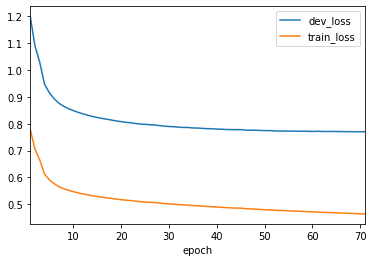

In [55]:
t = models_df[(models_df.embedding_dimension==50) & (models_df.hidden_dimension==100) & (models_df.num_layers==3)]
t = t.set_index('epoch')
t.dev_loss.plot()
t.train_loss.plot()
_ = plt.legend()

In [58]:
models_df.sort_values('dev_loss').iloc[0]

embedding_dimension      50.000000
hidden_dimension        100.000000
num_layers                3.000000
epoch                    69.000000
train_loss                0.465231
dev_loss                  0.770139
num_parameters         3819.000000
Name: 762, dtype: float64

Since the best "model" was at an earlier epoch I don't have access to it. So I'll train a model with that model's parameters and set the number of epochs to MEOW.

In [59]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=50, hidden_dimension=100, num_layers=3,
    max_epochs=69, early_stopping_rounds=69, batch_size=1024,
)

train_loss, dev_loss = lm.fit(train_df.pronunciation.values.tolist(), dev_df.pronunciation.values.tolist())

Epoch 1: train loss: 0.7643	assess loss: 1.1789
	Generated: in train: 1%, assess: 0%, novel: 99%
	 B UH0 AO0 AE1 AH0 S
	 T EY2
	 AE1
	 UW D SH K AE2
	 IY1 AY1 N L
Epoch 2: train loss: 0.7085	assess loss: 1.0957
	Generated: in train: 2%, assess: 0%, novel: 98%
	 N AH0 T M AH1 T N
	 HH B NG IH0 EY1 S IY1 T K T T
	 R AE1 AH0 EY1 N
	 K OW0 N JH T R N IH0
	 K D B AY1 OY0 D AH0
Epoch 3: train loss: 0.6563	assess loss: 1.0153
	Generated: in train: 4%, assess: 1%, novel: 95%
	 UW1 AH0 B NG M D R F N
	 NG IH2 G AE1 K ER0 EH2
	 AA2 W AA1 S Z M
	 W AO1 K B AH0 M L
	 OW1 N
Epoch 4: train loss: 0.6100	assess loss: 0.9442
	Generated: in train: 8%, assess: 1%, novel: 91%
	 G R AO1 S AH0 K AH0 L
	 B AW1 L B ER0
	 AA1 R AH0
	 S AE1 SH AH0 S S
	 L UH2 V IY1 B
Epoch 5: train loss: 0.5903	assess loss: 0.9143
	Generated: in train: 6%, assess: 0%, novel: 94%
	 K R AH1 S T AH0 N
	 M EH1 N P R M ER0 AY0 SH AH0 R M EY1 M OW0
	 S IH1 N T N ER0
	 IH0 K AO1 G R IY0 AH0 Z
	 IH0 T S AA1 N AA0 S IH0 V
Epoch 6: train

Epoch 44: train loss: 0.4825	assess loss: 0.7745
	Generated: in train: 19%, assess: 2%, novel: 79%
	 M EH1 D AH0 L
	 M AH0 K V OW1 D AH0
	 Y EH1 K AH0 V IH0 CH
	 G OW1 T AH0 M
	 K AA1 NG IH0 K
Epoch 45: train loss: 0.4816	assess loss: 0.7745
	Generated: in train: 15%, assess: 0%, novel: 85%
	 K EH1 L T ER2 N
	 AH0 S T R AA1 S ER0 S AH0 L
	 P AO0 R F EH1 L IY0 OW0
	 S AH1 M AH0 N T
	 S AH1 B D IY2
Epoch 46: train loss: 0.4806	assess loss: 0.7739
	Generated: in train: 19%, assess: 2%, novel: 79%
	 B AA1 T S L ER0
	 R AH0 B AO1 R D AH0 N
	 B AE1 P ER0 S AY2 N Z
	 K L AE1 NG S AH0 N IH0 N
	 AH0 P AA1 NG G AH0
Epoch 47: train loss: 0.4797	assess loss: 0.7735
	Generated: in train: 16%, assess: 2%, novel: 82%
	 V AA0 CH AA1 R T IY0
	 CH EY1 P UW0
	 R IY1 Z IY0 AH0 T IH2 M
	 L UW1 T ER0 Z
	 D HH IY1 T K OW0
Epoch 48: train loss: 0.4785	assess loss: 0.7728
	Generated: in train: 16%, assess: 6%, novel: 78%
	 B R AH1 SH
	 D AY1 AH0
	 EH1 L M EY2 K IH0 NG
	 B ER1 D IY0
	 M IH1 N S IH0 Z
Epoch 49: 

In [62]:
test_loader = build_data_loader(test_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(test_loader)

1.0080862045288086

In [64]:
dev_loader = build_data_loader(dev_df.pronunciation.values.tolist(), lm.phoneme_to_idx)
lm.evaluate(dev_loader)

0.7703387141227722

* compute the test error for the final model. plot the train, dev, and test errors

## Training the Final Model ##
Now that we've found the best parameters for the model according to the dev set we'll train a final model using all of the data. This should increase model performance overall since more data is better, but is also necessary since we'll be using the model to predict probabilities of all English words below. If some of those words weren't in the training set they would artificially get lower probabilities. (Another approach here could be to train a model on e.g. 4/5 folds of the data and make predictions about the remaining 1/5, doing that 5 times to get unbiased predictions for all data, but this would have taken much longer to run.)

In [7]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=50, hidden_dimension=100, num_layers=3,
    max_epochs=69, early_stopping_rounds=69, batch_size=1024,
)

train_loss, dev_loss = lm.fit(df.pronunciation.values.tolist())

Epoch 1: train loss: 0.7492loss: 0.7402
	 UH1
	 K SH K AH0 K AH0 S IH0 N
	 UW0 AO0 UW AH0 M B AE1 L M
	 IY0 IY2 AA1 M IH0 ER0
	 EH2 SH EY2 AH2 K IH0 T N IY0
Epoch 2: train loss: 0.6937loss: 0.7019
	 F AA1 N N NG IH0
	 P IH0 UW1 L IH0 SH IY0
	 L M EY1 AH0 S
	 JH HH IH1 R NG
	 R NG G IY0 AH0 CH Z G N
Epoch 3: train loss: 0.6319loss: 0.5828
	 D T AE1 Z AH0 S L IY2
	 P AE2 T AA1 N Z
	 M AH0 L EY1 V AH0 M K AH1 B S EY2
	 L AH0 N R EH1 L IH0
	 D AY1 R IH0 Z
Epoch 4: train loss: 0.5988loss: 0.6162
	 S AE1 K B IH0 N Z
	 AY2 F IY1 D
	 B UH0 D R AE1 S HH AH0 L OY0
	 AE1 V AH0 L AH0 P IY0
	 D OW1 V EH1 SH T L ER0
Epoch 5: train loss: 0.5792loss: 0.5845
	 V AA2 R T UW2 N AH0 N S IH2 N T IY0 F IH0 NG T ER0
	 Y AH0 S T R IH1 N
	 R EH0 S D AY1 B AH0 L
	 IH0 L L AE1 N JH AH0 T
	 P Y AH1 R OW0
Epoch 6: train loss: 0.5655loss: 0.5551
	 B IY1 K T AH0 N
	 T AO1 R EH2 G IH0 N D
	 M IH1 V AH0 N AY2 Z
	 G ER1 R OW0
	 SH EH1 Z
Epoch 7: train loss: 0.5559loss: 0.5417
	 HH AO1 L Z Z
	 HH IH1 S K IY0
	 F Y UW1 Y

Epoch 60: train loss: 0.4661loss: 0.4701
	 T R EY1 AW0
	 L AE1 N D AH2 P
	 S L AY1 G ER0
	 AA1 R W AW0 D
	 JH AW1 T IY0
Epoch 61: train loss: 0.4652loss: 0.4803
	 Y UW0 L EY1
	 T UH1 K
	 B AH1 N IY0
	 AE1 G N AO2 K
	 HH AH1 N S AH0 L
Epoch 62: train loss: 0.4649loss: 0.4578
	 G AH1 Z W IH2 NG K
	 L AA0 K UW1 M IH0 K
	 N OW0 T EY1 K AH0 N
	 R IY0 K AA1 T
	 N OW1 F IY2 N D
Epoch 63: train loss: 0.4640loss: 0.4636
	 K IH0 R AA1 P IY0
	 HH W IH1 P
	 S AY1 D L AH0 N D
	 IH2 N S T IH0 F IH1 K IY0
	 CH EH1 K W EH2 L
Epoch 64: train loss: 0.4636loss: 0.4599
	 F OW1 M
	 P AH0 K T IH1 V
	 K AH0 CH L IY1 T OW0
	 T AE1 N AH0 L
	 T AA1 D
Epoch 65: train loss: 0.4625loss: 0.4686
	 K AH0 N S AY1 S M AH0 N T
	 AH0 M AE1 S K AH0 L
	 F EH1 S T
	 K AE1 N F OW2 N Z
	 S K AH1 SH
Epoch 66: train loss: 0.4625loss: 0.4496
	 L IH1 NG G M AH0 N
	 AO1 R AH0 K
	 S T EH1 R AH0
	 V IY1 CH
	 K AH0 N S AA1 N AH0 G AH0 N T L IY0
Epoch 67: train loss: 0.4617loss: 0.4664
	 B R EY1 K S
	 HH AY1 L IH0 NG V IH2 L
	 F R AE1

## What Words are the Most and Least Englishy? ##
The model should now have a good representation of a normal English word is. So I can run the model over the entire set of pronunciations in the Pronouncing Dictionary and identify the ones that have high and low probability of being English.

One challenge here is that long words almost always have lower probabilities than shorter words. 

In [8]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

CPU times: user 3min 8s, sys: 4.19 s, total: 3min 12s
Wall time: 3min 12s


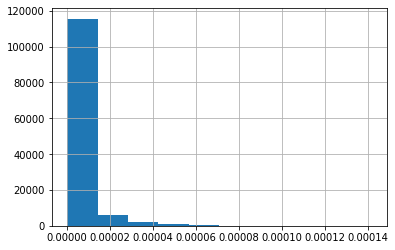

In [9]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=10)

In [41]:
with open('lm_2.pt', 'wb') as fh:
    torch.save(lm, fh)

### Comparing Multiple Pronunciations ###

In [ ]:
df[df.word == 'with'].sort_values('probability', ascending=False)

In [ ]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

In [ ]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

In [ ]:
df[df.word == 'february'].sort_values('probability', ascending=False)

In [ ]:
df.word.value_counts()

In [ ]:
lm.calculate_probability(['P', 'R', 'IY1', 'M'])

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'M'])

In [ ]:
lm.calculate_probability(['S', 'T', 'R', 'UW1', 'Z'])

## Can the Model Generate Novel Words? ##

* proportion of words that are novel
* proportion of words (from a sample) that look good to me
* 10 randomly sampled words. show them and play the word. ARPABET | IPA | my best spelling guess | play button 



compare with overgenerated model. probably way more that aren't novel

In [ ]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

### Probability of Next ###

In [ ]:
pronunciation = ['CH', 'EH0', 'N', 'V', 'AY2', 'R', 'AH0', 'N', 'M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['S', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
pronunciation = ['F', 'EH1', 'B', 'Y', 'AH0']


next_probs = lm.next_probabilities(pronunciation)

for phoneme, probability in sorted(next_probs.items(), key=lambda p: -p[1]):
    print(f'[{probability:.4f}] {phoneme}')

## What Rules is the Model Actually Learning? ##

In [ ]:
* Does it learn that PAD comes after end?

In [ ]:
* Does the first phoneme after START follow the distribution of the training corpus?

In [ ]:
* Does the length 

# END #

### Play with Embeddings ###

In [ ]:
def most_similar_phonemes(lm, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, lm.embedding_for('DH'))

In [ ]:
embeddings = lm.embeddings
# embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 15
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

In [ ]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

# new = lm.embedding_for('TH') + voicing
new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication
# new = lm.embedding_for('G') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:10]

In [ ]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([lm.embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([lm.embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(lm, voicing + lm.embedding_for('S'))

In [ ]:
most_similar_phonemes(lm, voicing)

In [ ]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = lm.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'K', 'B')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4f}] {phoneme}')


In [ ]:
from phoneme_lm import START
phoneme_idx = lm.phoneme_to_idx[START]

In [ ]:
output, hidden_state = lm(torch.LongTensor([phoneme_idx]).unsqueeze(0))

In [ ]:
hidden_state.shape

In [ ]:
hidden = torch.zeros(1, 1, 10)

lm(torch.LongTensor([phoneme_idx]).unsqueeze(0), hidden)